# 1. Description

__Aim:__   
Practise with `time series EDA` and `time series clustering`   

__Case:__   
Find cryptocurrencies which behaviours are different with bitcoin - `BTC` during 30 days, 3 days, 1 hour.   


__Plan:__   
1. Download data using [cryptocompare](https://pypi.org/project/cryptocompare/).
2. EDA. 
3. Test vanila TimeSeries kNN. Analyze results.
4. Test kNN (DTW - Dynamic Time Warping). Analyze results.
5. Summarize results.

# 2. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from tqdm.autonotebook import tqdm

from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import cryptocompare

import datetime

C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\parshin_sa2\AppData\Local\Temp\ipykernel_5644\3429534824.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Custom

In [2]:
from crypto_scripts.cryptocompare_scrips import download_ticket_price
from crypto_scripts.plot_funcs import plot_results, plot_cluster_tickers, plot_and_get_pca, plot_elbow
from crypto_scripts.process_results import get_non_btc_tickets

# 3. Global params

In [3]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [7]:
SEED = 42
# Some tickets (currencies) are not in exchange='CCCAGG'. Therefore let's download many tickets and take existing in the exchange. 
NUM_OF_TICKETS_DOWNLOAD = 5000
# Take 500 tickets. Note, that API do not get possibility to download 500 tickets with mentioned discreteness.
# Поэтому тикеты были также сохранены в файлах с данным ноутбуком. Флаг EXTRACT=False значит подгрузить зараннее подготовленные данные
# Also tickets were saved in files. Flag EXTRACT=False means to upload earlier prepared data.
NUM_OF_TICKETS = 500
END_TIME = datetime.datetime(2023,9,20,0,0,0,0)

TARGET_TICKET = "BTC"

DATA_FOLDER = "./data/crypto/"

# 4. Choose tickets

In [5]:
crypto_tickets = cryptocompare.get_coin_list(format=True)[:NUM_OF_TICKETS_DOWNLOAD]
print("Num of cryptocurrencies:", len(crypto_tickets))
assert TARGET_TICKET in crypto_tickets

Num of cryptocurrencies: 5000


# 5. Download prices

In [8]:
EXTRACT = False

DF_NAMES = ["day_30", "hour_72", "minute_60"]
dfs_prices = {}

if EXTRACT:
    funcs = [cryptocompare.get_historical_price_day, cryptocompare.get_historical_price_hour, cryptocompare.get_historical_price_minute]
    periods = [30, 3*24, 60]
    tickets = crypto_tickets.copy()

    for func, period, name in zip(funcs, periods, DF_NAMES):
        print(f"Start {name} uploading")
        dfs_prices[name] = download_ticket_price(func, tickets, period, NUM_OF_TICKETS, END_TIME)
        # to not search second time
        tickets = list(dfs_prices[name].columns)
    for key in dfs_prices:
        dfs_prices[key].to_csv(DATA_FOLDER + "cryptos_" + key + ".csv", index=True)
else:
    for key in DF_NAMES:
        dfs_prices[key] = pd.read_csv(DATA_FOLDER + "cryptos_" + key + ".csv", index_col="time")

# 6. EDA

In [9]:
dfs_prices[key].columns[~dfs_prices[key].isnull().sum() > 0]

Index([], dtype='object')

In [10]:
for key in DF_NAMES:
    nan_counts = dfs_prices[key].isnull().sum()
    nan_cols = dfs_prices[key].columns[~dfs_prices[key].isnull().sum() > 0]
    print("Nans cols", nan_cols)

Nans cols Index([], dtype='object')
Nans cols Index([], dtype='object')
Nans cols Index([], dtype='object')


In [11]:
NAMES_TO_SHOW = [TARGET_TICKET, "BCN", "BTS", "PNC", "HMP"]
df_name_scaled = {}

for df_name in DF_NAMES:
    print(df_name)
    df_transformed = dfs_prices[df_name].loc[:, NAMES_TO_SHOW]
    df_name_scaled[df_name] = pd.DataFrame(StandardScaler().fit_transform(df_transformed), columns=df_transformed.columns, index=df_transformed.index)
    df_name_scaled[df_name].index.name = "time"
    display(df_name_scaled[df_name].describe())

day_30


BTC           BCN           BTS           PNC           HMP
count  3.100000e+01  3.100000e+01  3.100000e+01  3.100000e+01  3.100000e+01
mean   9.698335e-15  1.253478e-16  1.096793e-14  4.315544e-16  6.489433e-15
std    1.016530e+00  1.016530e+00  1.016530e+00  1.016530e+00  1.016530e+00
min   -1.706823e+00 -1.260321e+00 -2.121839e+00 -8.363656e-01 -2.062278e+00
25%   -7.125848e-01 -1.242094e+00 -4.747589e-01 -6.942392e-01 -6.405080e-01
50%   -3.079731e-01 -1.931826e-01 -9.387795e-02 -5.664276e-01 -2.384904e-01
75%    6.913106e-01  7.861148e-01  6.658417e-01  1.044509e+00  5.263236e-01
max    2.662722e+00  1.880616e+00  2.248591e+00  1.738270e+00  2.977651e+00

hour_72


BTC           BCN           BTS           PNC           HMP
count  7.300000e+01  7.300000e+01  7.300000e+01  7.300000e+01  7.300000e+01
mean  -1.411352e-14 -1.410972e-15  1.778790e-14 -1.143986e-14 -5.627158e-15
std    1.006920e+00  1.006920e+00  1.006920e+00  1.006920e+00  1.006920e+00
min   -1.200318e+00 -8.438604e+00 -1.553117e+00 -1.223211e+00 -1.243458e+00
25%   -8.712704e-01  2.427016e-02 -7.866407e-01 -8.640219e-01 -8.652392e-01
50%   -2.937071e-01  8.598996e-02 -2.814630e-01 -2.893194e-01 -2.807200e-01
75%    9.146642e-01  2.348436e-01  7.463123e-01  1.111518e+00  1.129003e+00
max    2.051942e+00  3.473915e-01  2.958642e+00  2.189085e+00  2.194891e+00

minute_60


BTC           BCN           BTS           PNC           HMP
count  6.100000e+01  6.100000e+01  6.100000e+01  6.100000e+01  6.100000e+01
mean  -3.834528e-13  2.730057e-16 -2.584454e-16 -2.377169e-13  4.148594e-13
std    1.008299e+00  1.008299e+00  1.008299e+00  1.008299e+00  1.008299e+00
min   -2.181656e+00 -1.122299e+00 -1.487059e+00 -1.971323e+00 -1.904564e+00
25%   -7.980796e-01 -1.122158e+00 -1.486621e+00 -9.391280e-01 -8.435739e-01
50%    1.533760e-01  8.911328e-01  6.725927e-01  9.306674e-02  2.174160e-01
75%    7.968140e-01  8.911328e-01  6.725927e-01  6.091641e-01  7.479109e-01
max    1.707166e+00  8.911328e-01  6.725927e-01  2.157456e+00  1.808901e+00

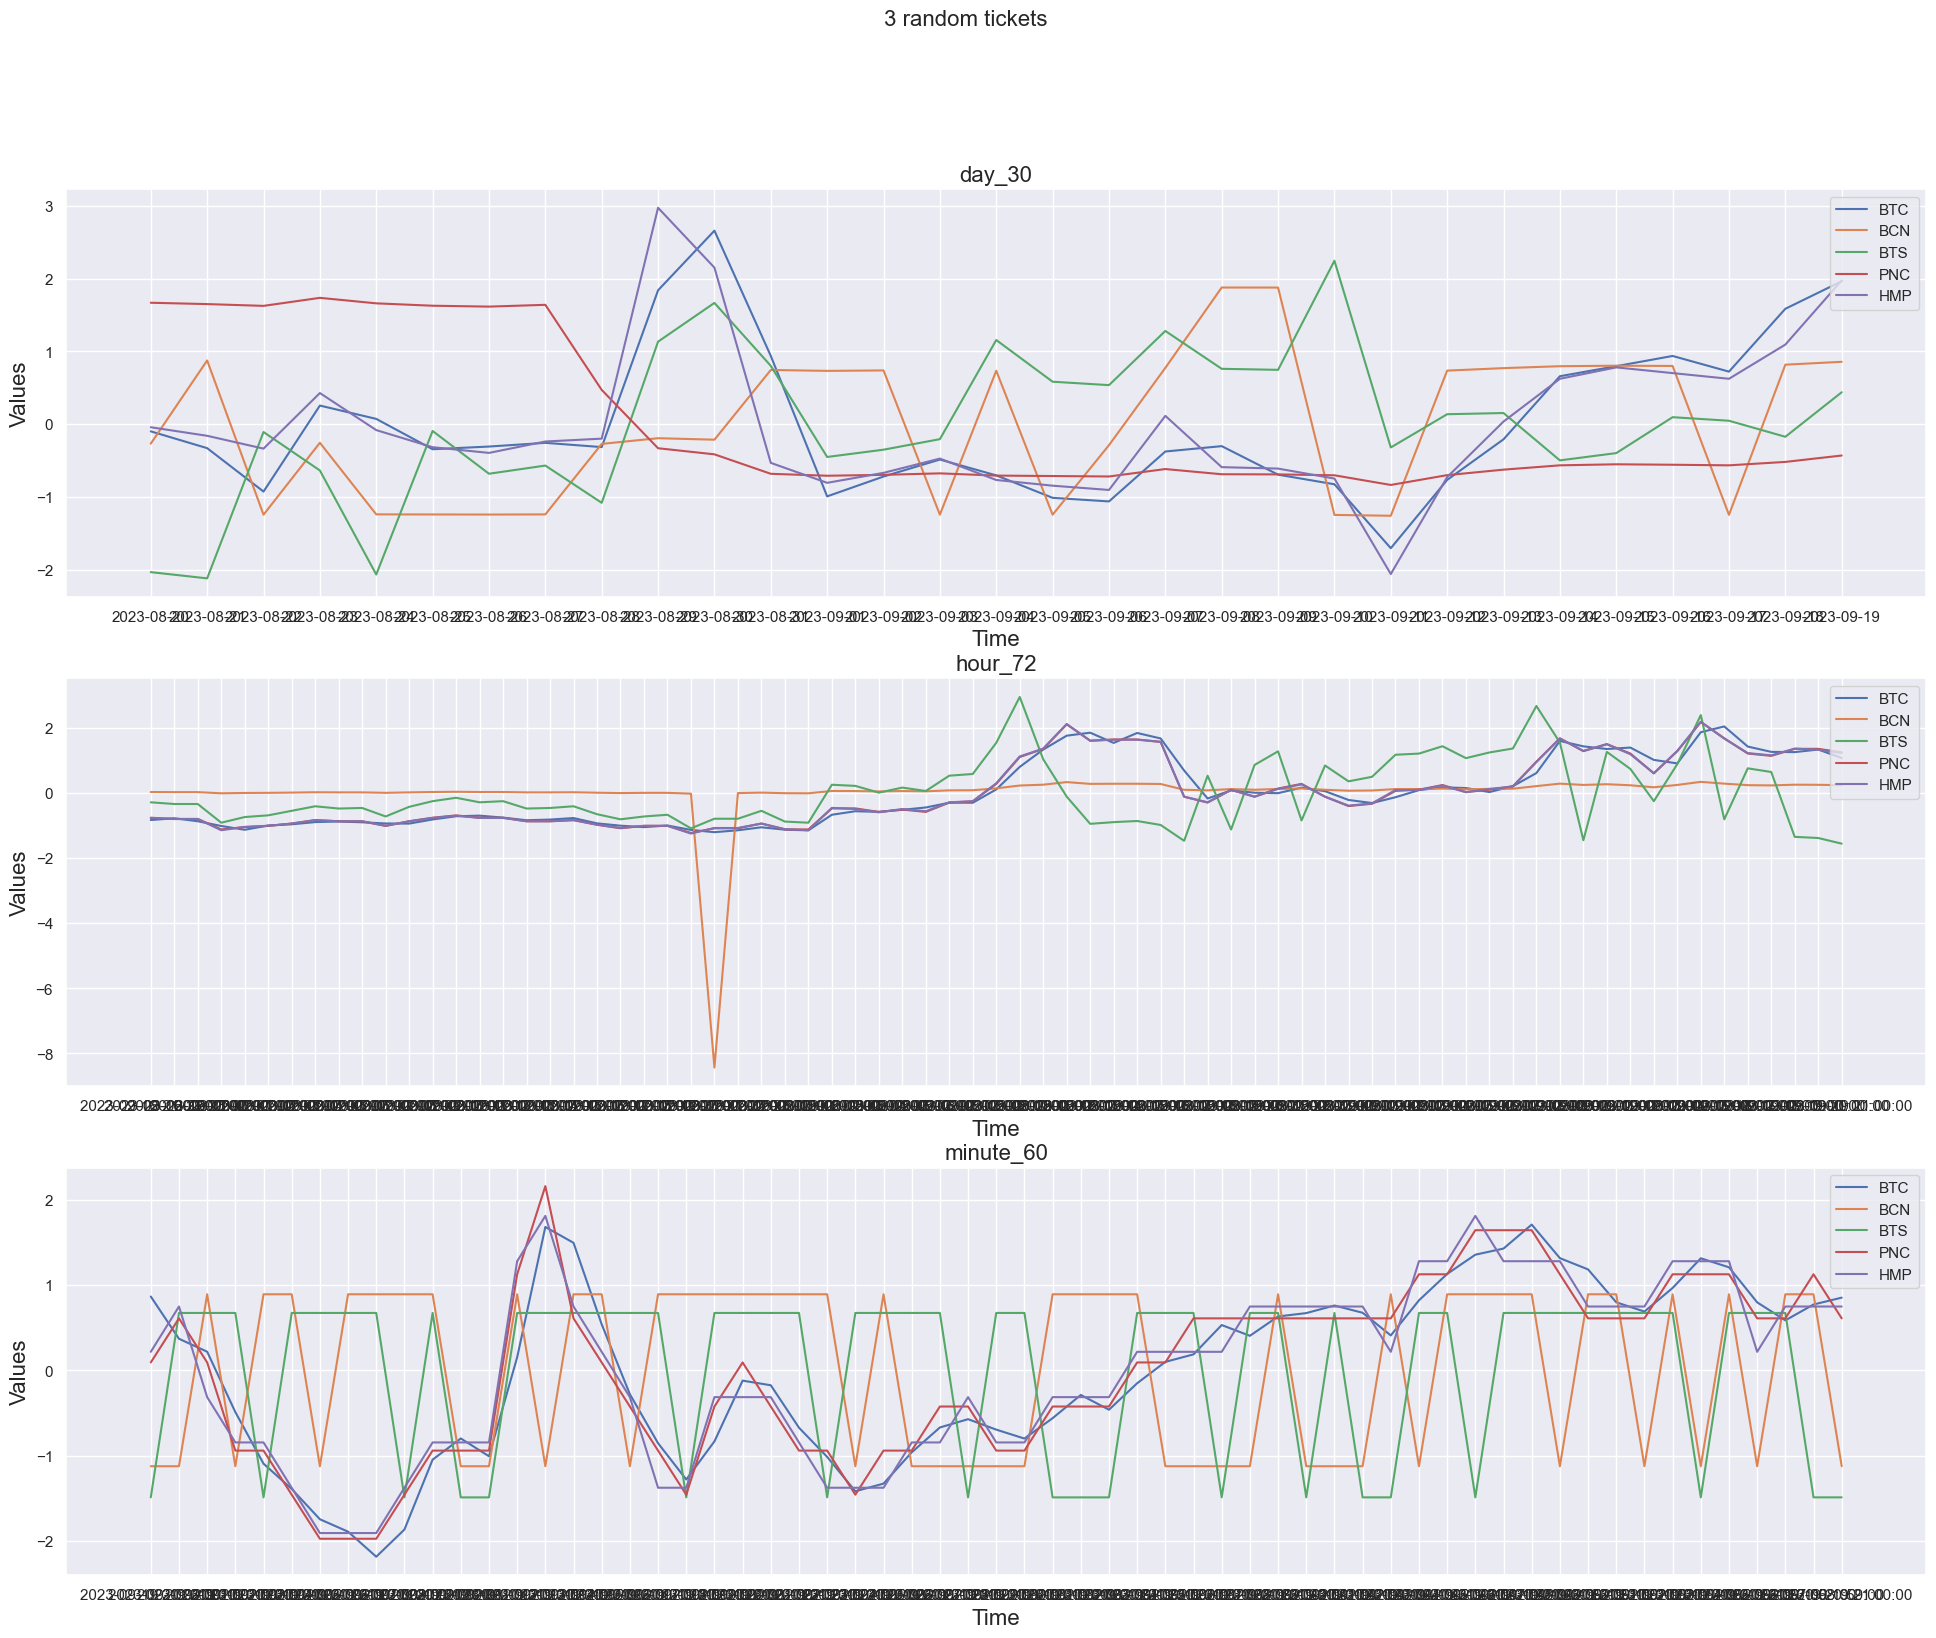

In [12]:
xlabel = 'Time'
ylabel = 'Values'

f, axarr = plt.subplots(nrows=len(df_name_scaled), ncols=1, figsize=(24,18))
f.suptitle(f"{len(df_name_scaled)} random tickets", fontsize=16)
 
for plot_no, col_key in enumerate(df_name_scaled):
 
    # label = labels[plot_no]
    axtitle = col_key
    ax = axarr[plot_no]
    ax.set_title(axtitle, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    for i, row_name in enumerate(df_name_scaled[col_key]):
        ax.plot(df_name_scaled[col_key][row_name],
                linestyle='-', color=PALETTE[i], label=row_name)
    ax.legend(loc="upper right")


Some tickets looks similar. For example, __BTC__ and __HMP__.  

# 7. Clustering, basic kMeans

Discover data based on 30 days data, for other periods will show outputs only

In [13]:
df_name = 'day_30' # 'day_30', 'hour_72', 'minute_60']

### Choose hyperparams

In [14]:
scaler = StandardScaler()
dfs_prices_scaled = {}

for key in DF_NAMES:
    dfs_prices_scaled[key] = scaler.fit_transform(dfs_prices[key]).T

100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


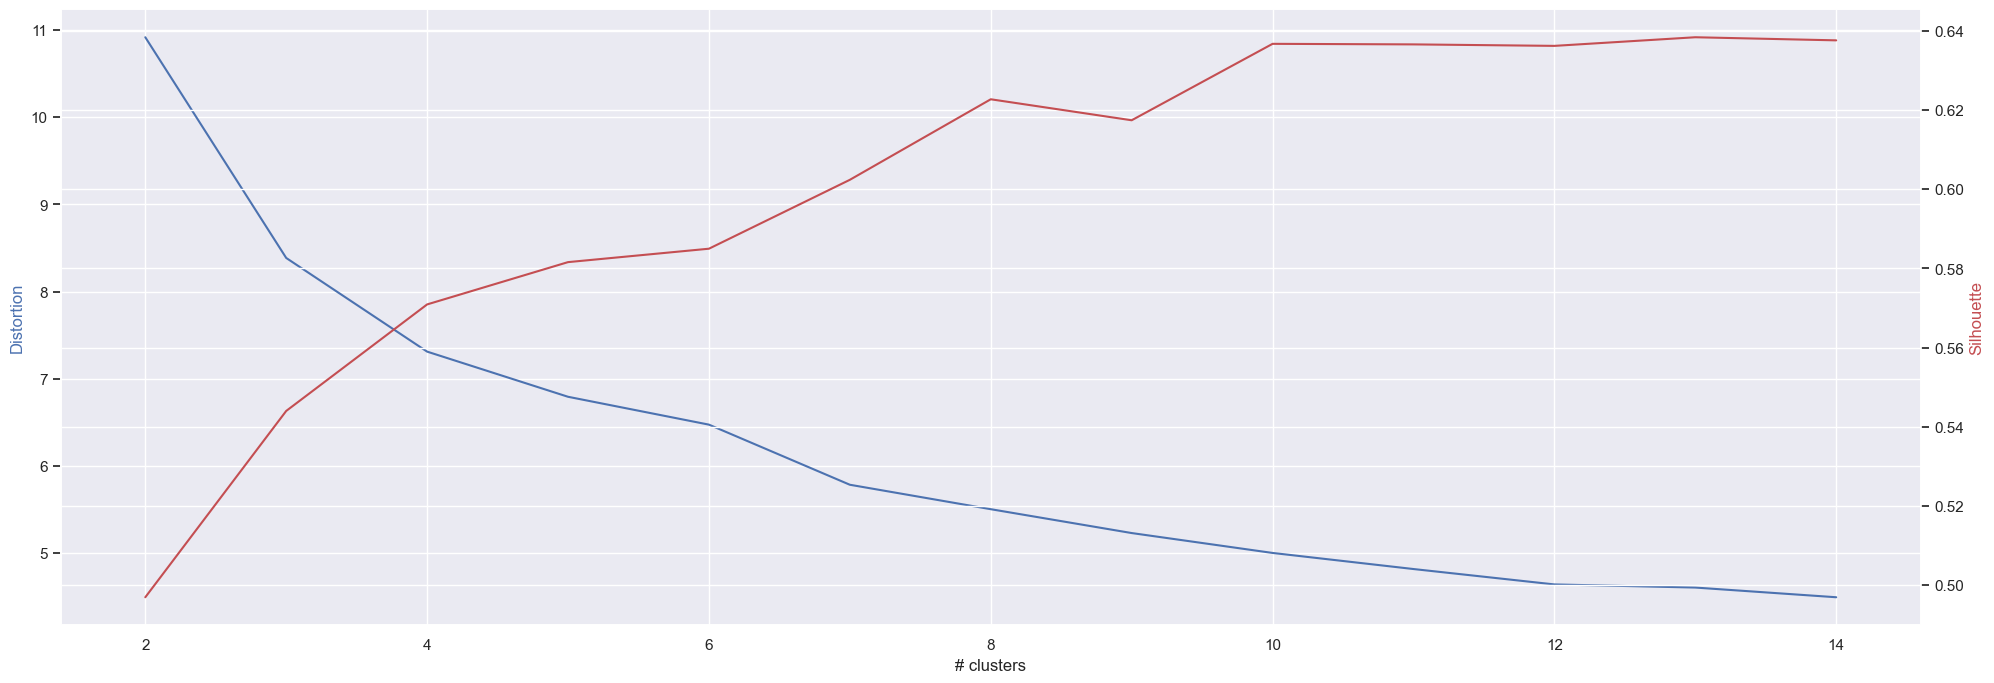

In [15]:
plot_elbow(dfs_prices_scaled[df_name], SEED)

6 and 10 looks optimal number of clusters

In [16]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10, random_state=SEED)
ts_kmeans.fit(dfs_prices_scaled[df_name])

TimeSeriesKMeans(max_iter=10, n_clusters=6, n_jobs=6, random_state=42)

### Plot results

In [17]:
dfs_prices_clusters = dfs_prices[df_name].T
dfs_prices_clusters['cluster'] = ts_kmeans.predict(dfs_prices_scaled[df_name])
print("BTC cluster is:", dfs_prices_clusters.loc[TARGET_TICKET, 'cluster'])

BTC cluster is: 0


c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(


Plot mean cluster centroids

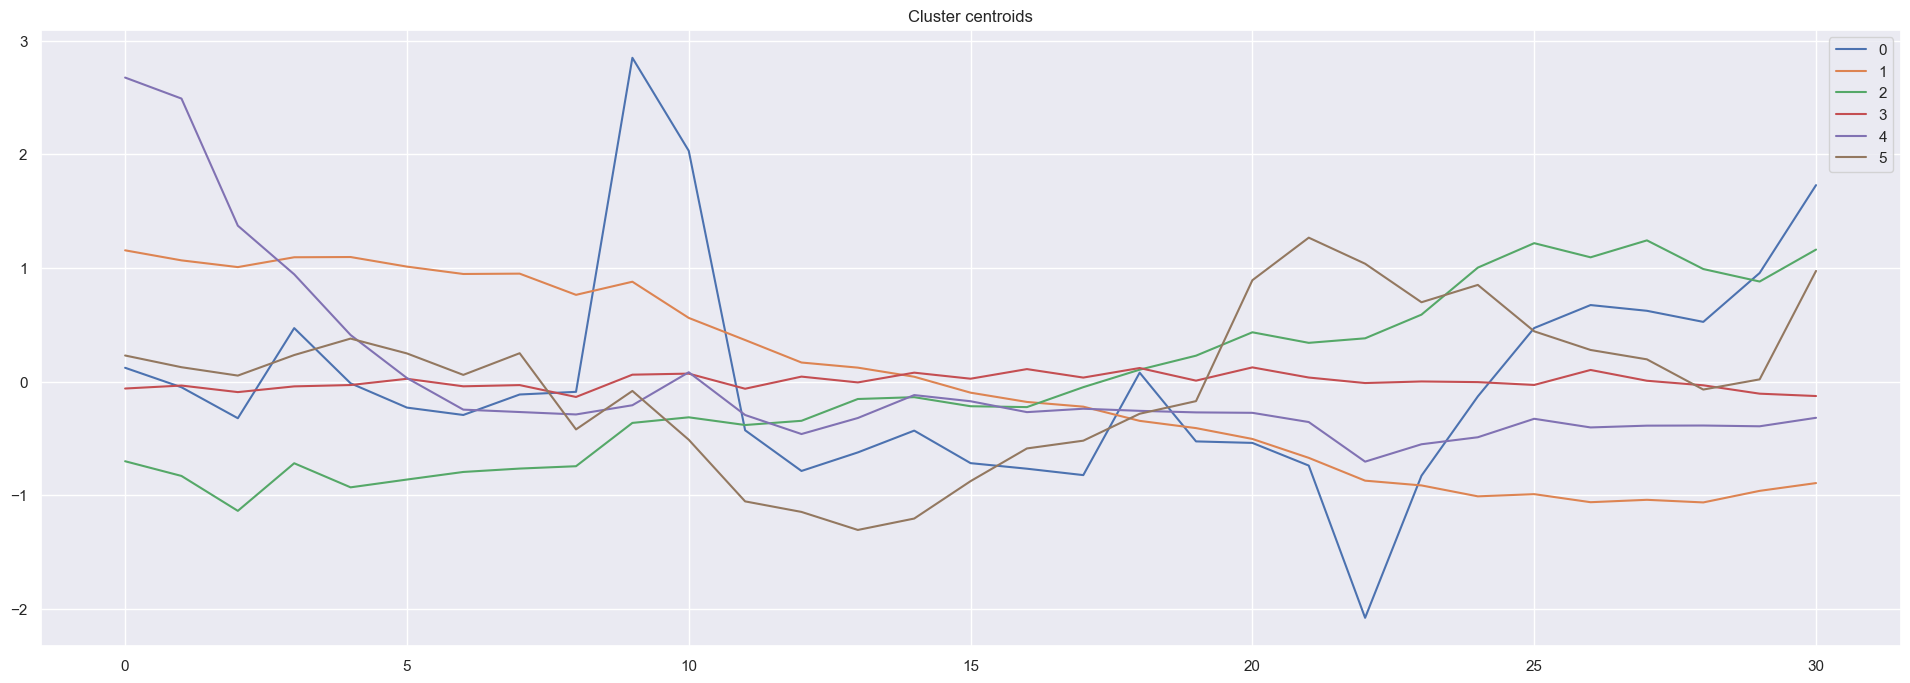

In [18]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids") # Быки и медведи
plt.legend()
plt.show()

__BTC cluster looks different from others__

                          Cluster number: 0


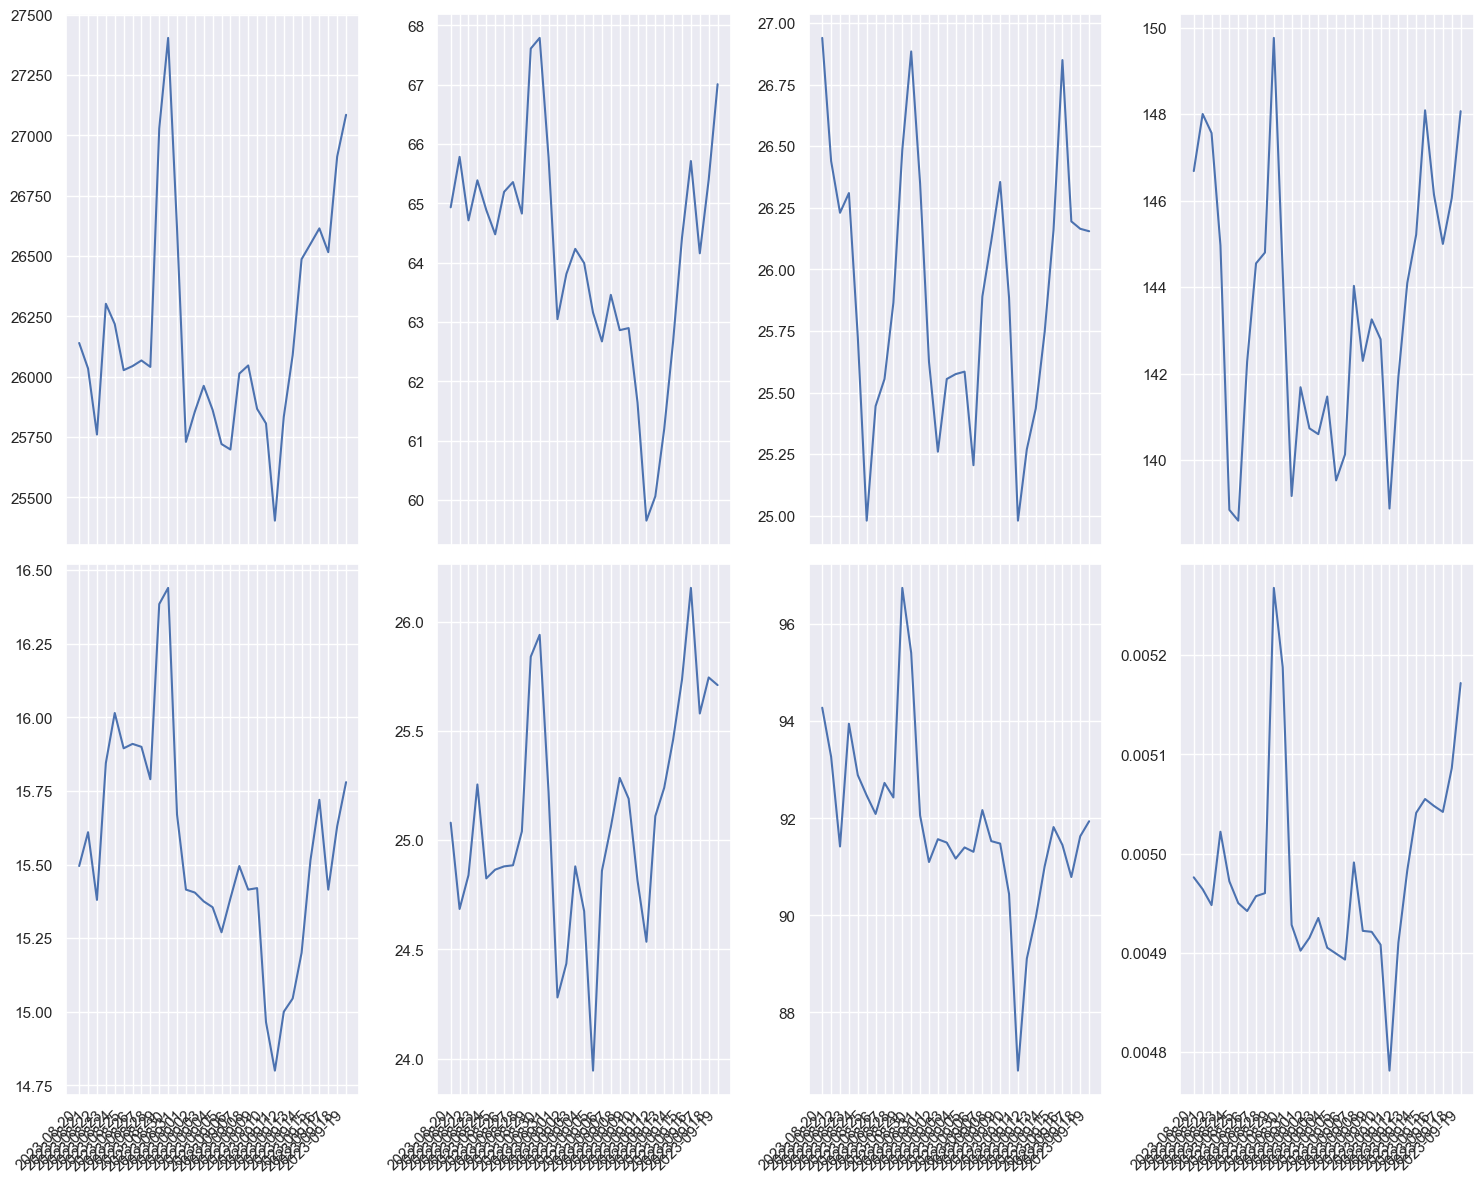

                          Cluster number: 1


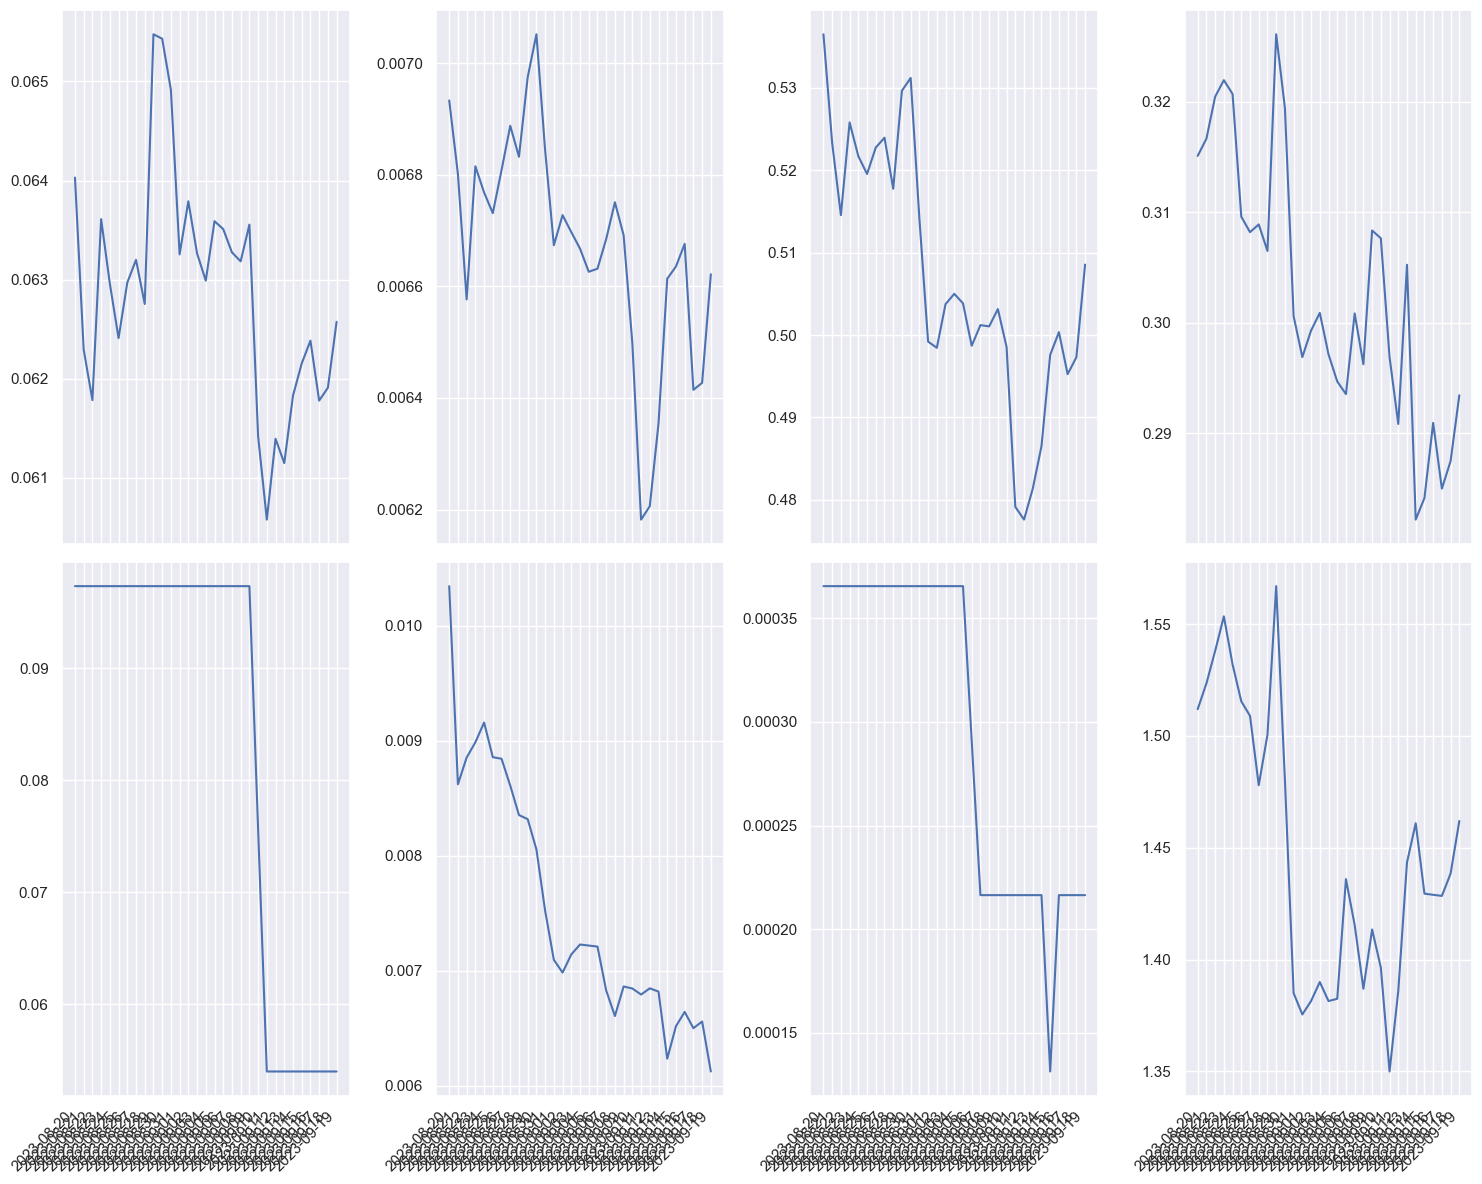

                          Cluster number: 2


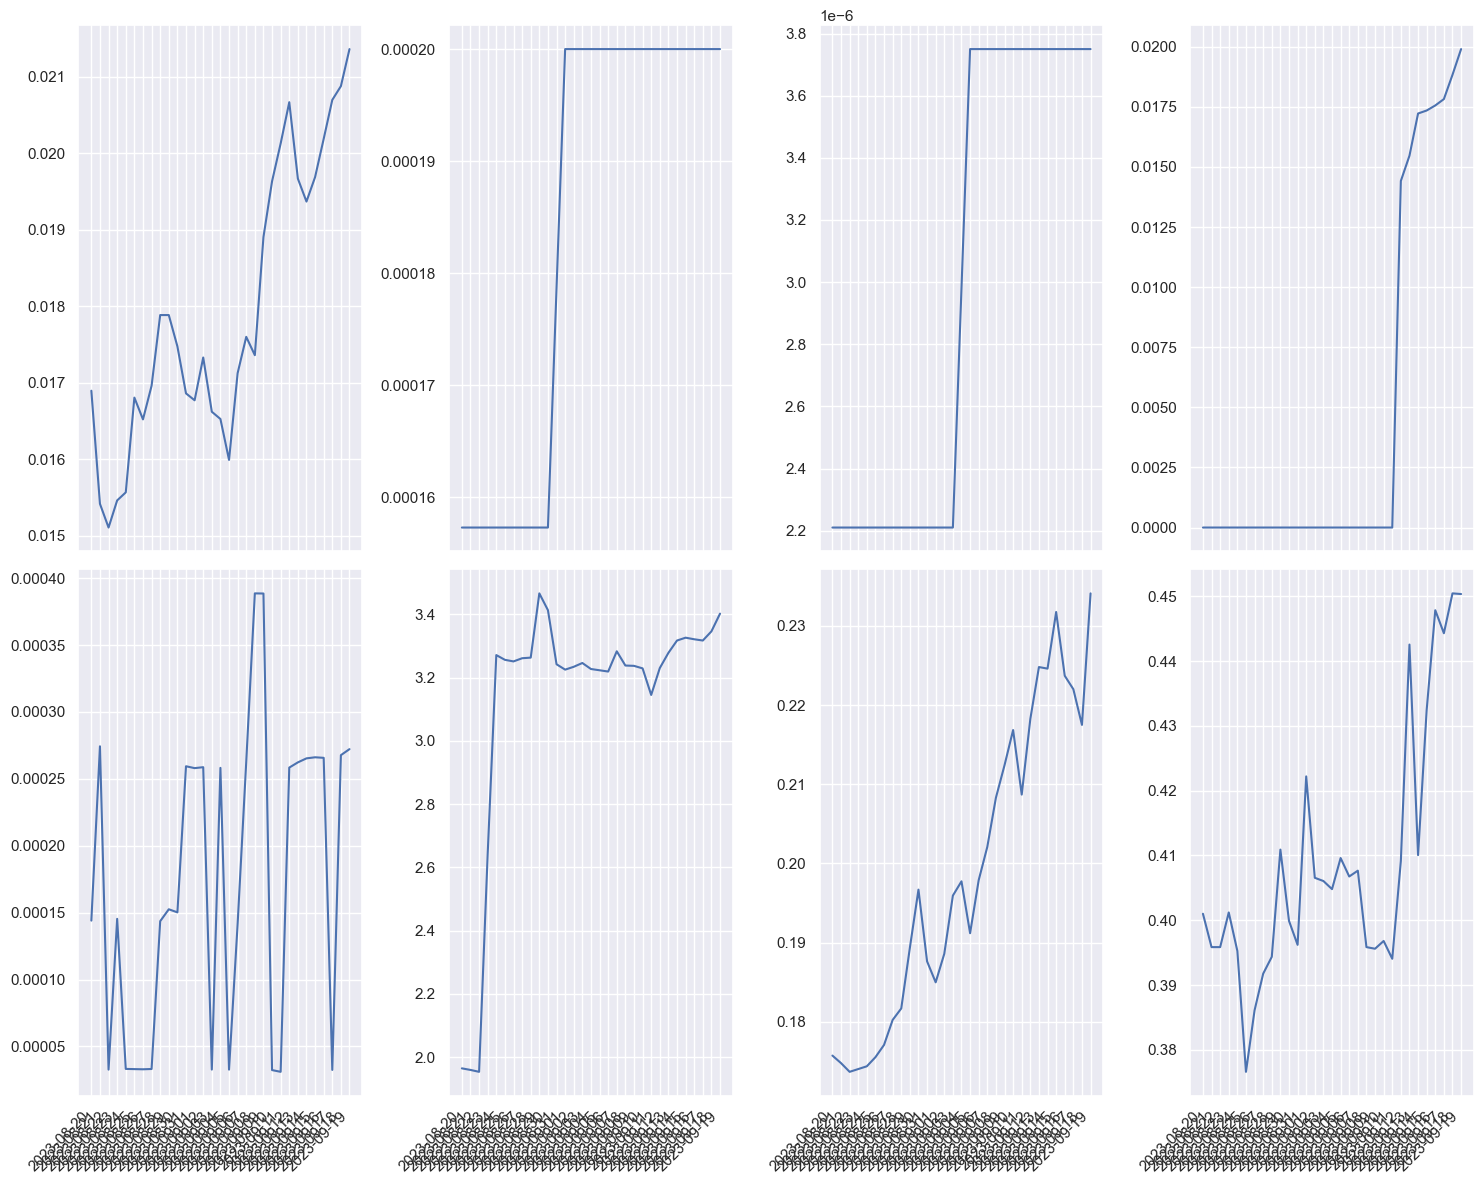

                          Cluster number: 3


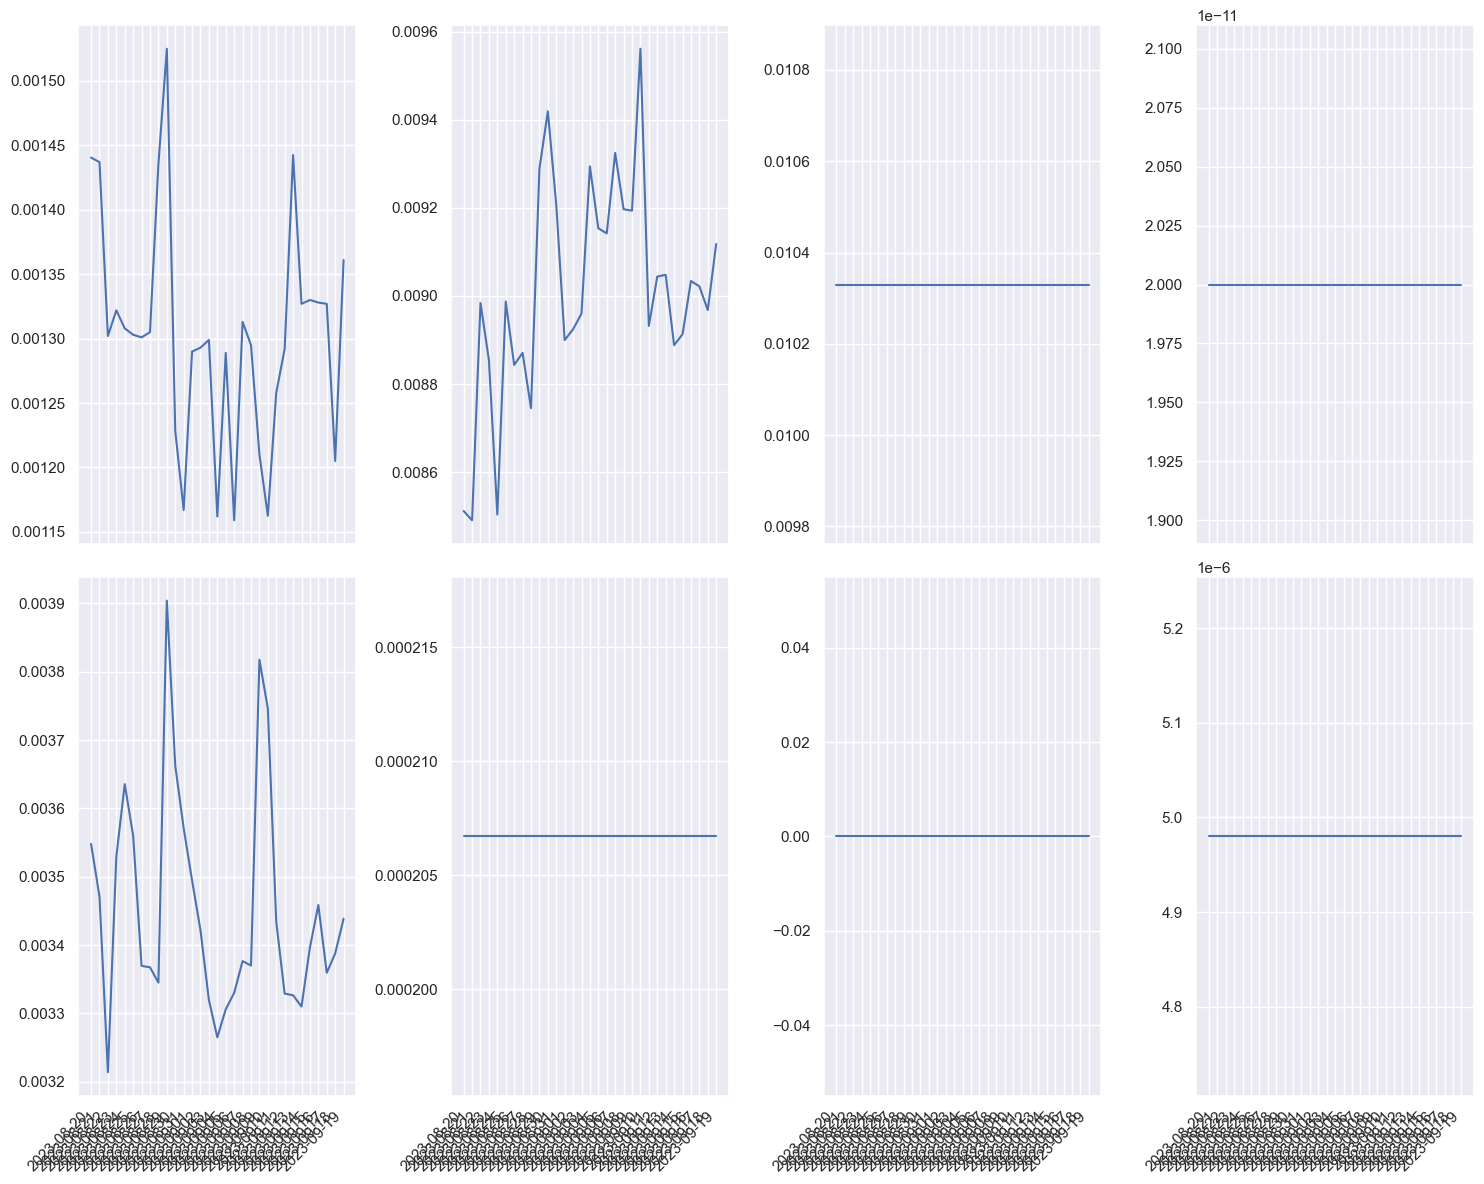

                          Cluster number: 4


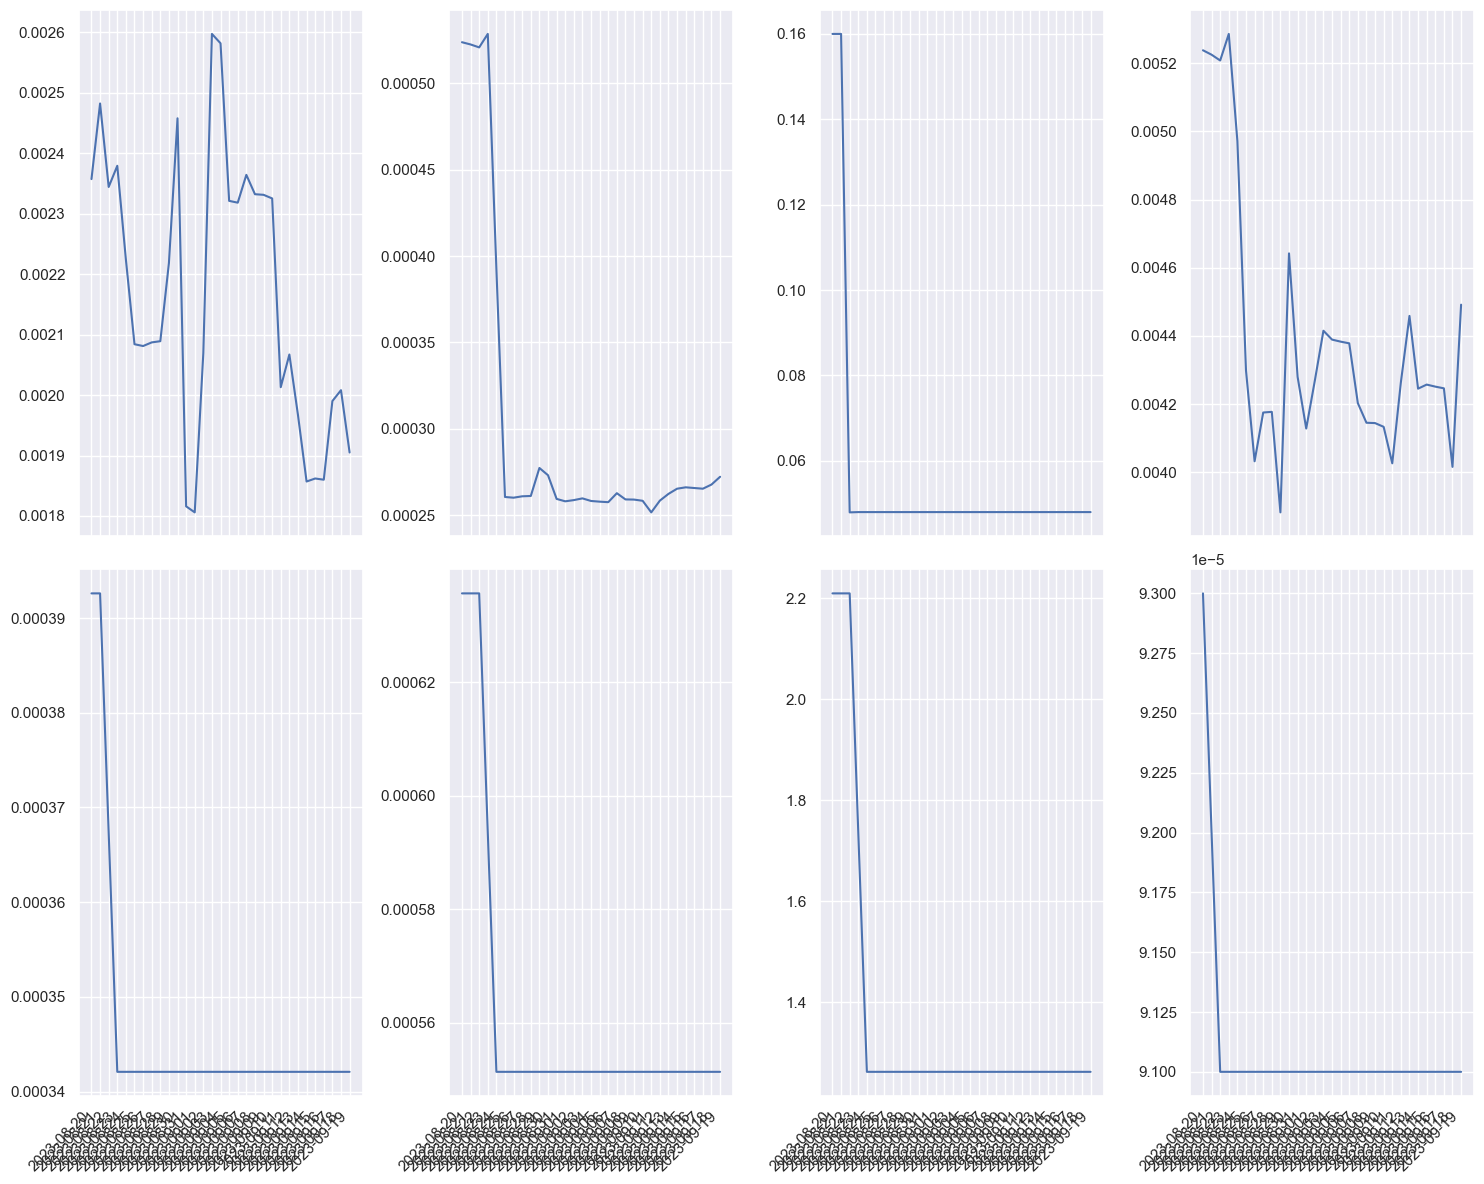

                          Cluster number: 5


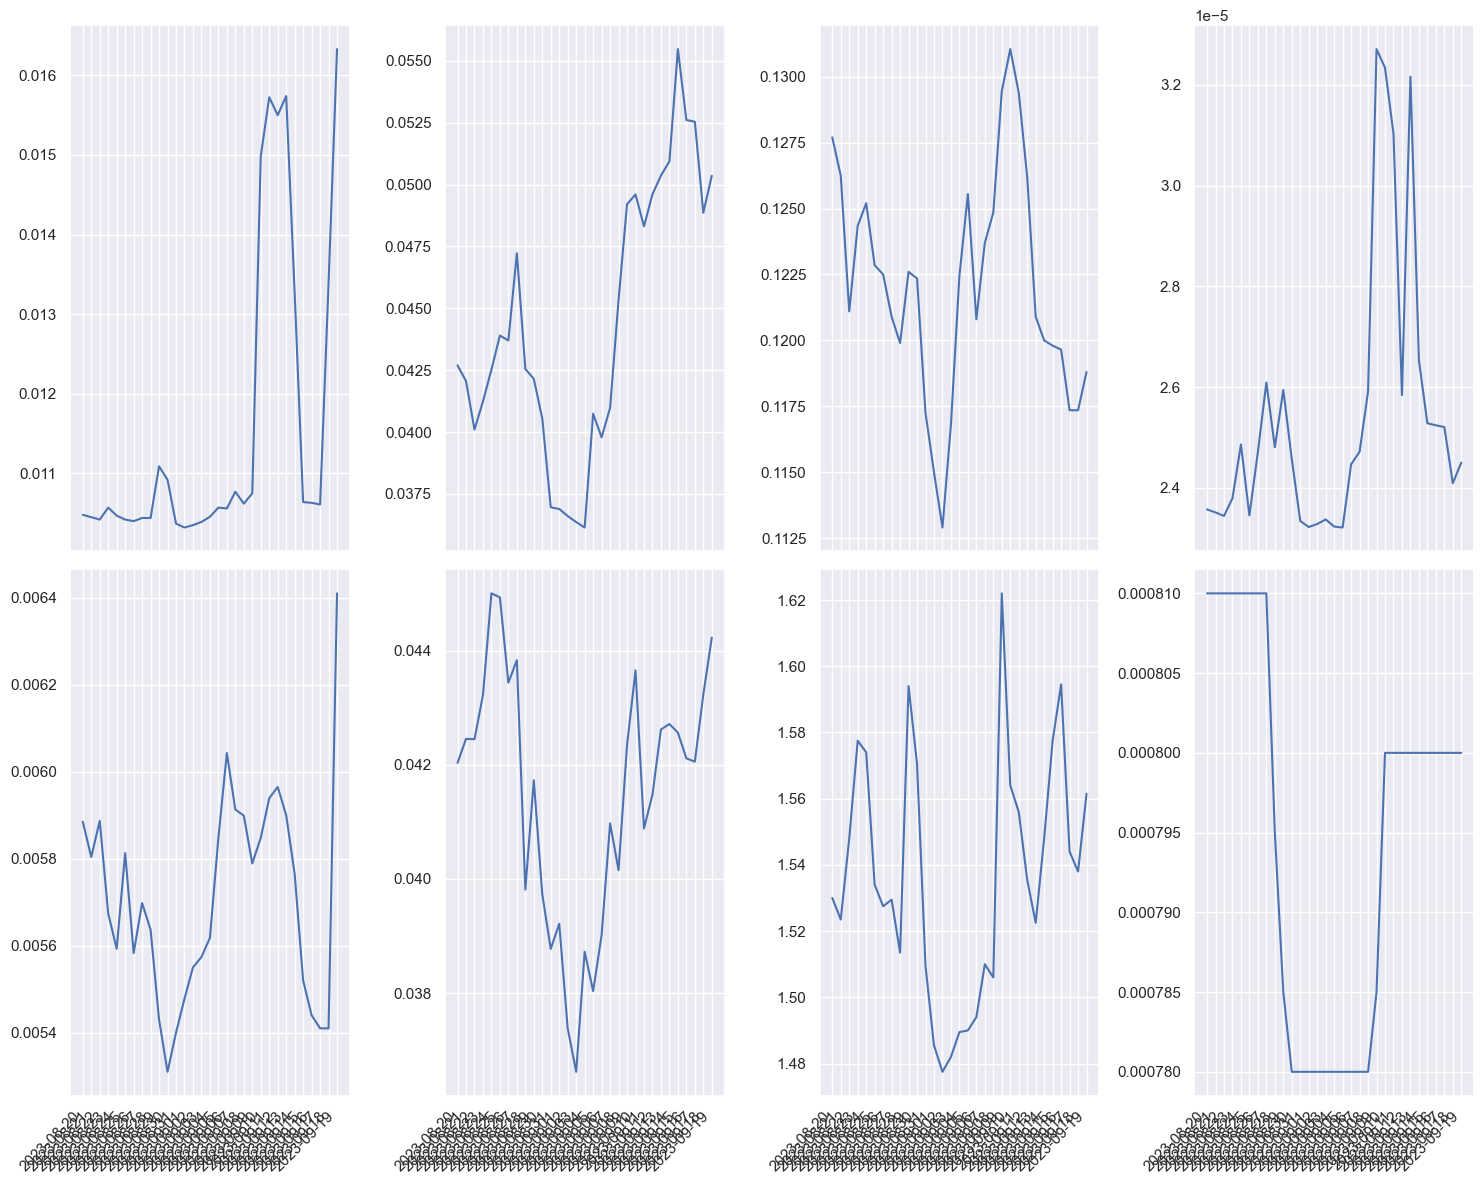

In [19]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(dfs_prices_clusters[dfs_prices_clusters.cluster==cluster])

Cluster with bitcoin have oscillatory behaviour. Others have a trend of increasing, decreasing or stable tendency.

Explained variance of 2 components 0.6656378890647714


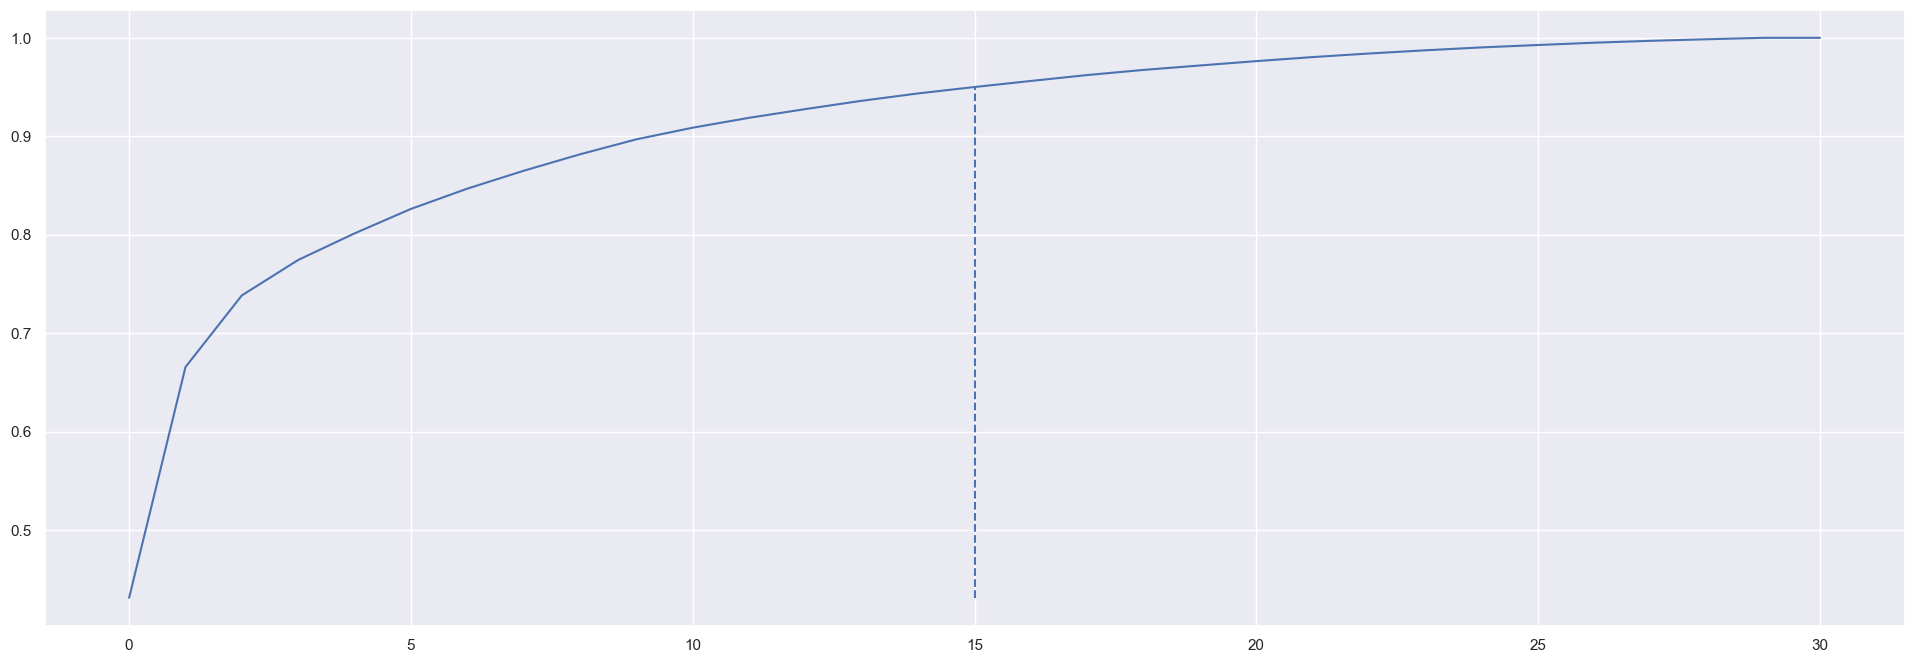

In [20]:
pca_transformed = plot_and_get_pca(dfs_prices_scaled[df_name], SEED, is_plot=True)

In [21]:
tsne = TSNE(n_jobs=6, random_state=SEED)
tsne_transformed = tsne.fit_transform(pca_transformed)

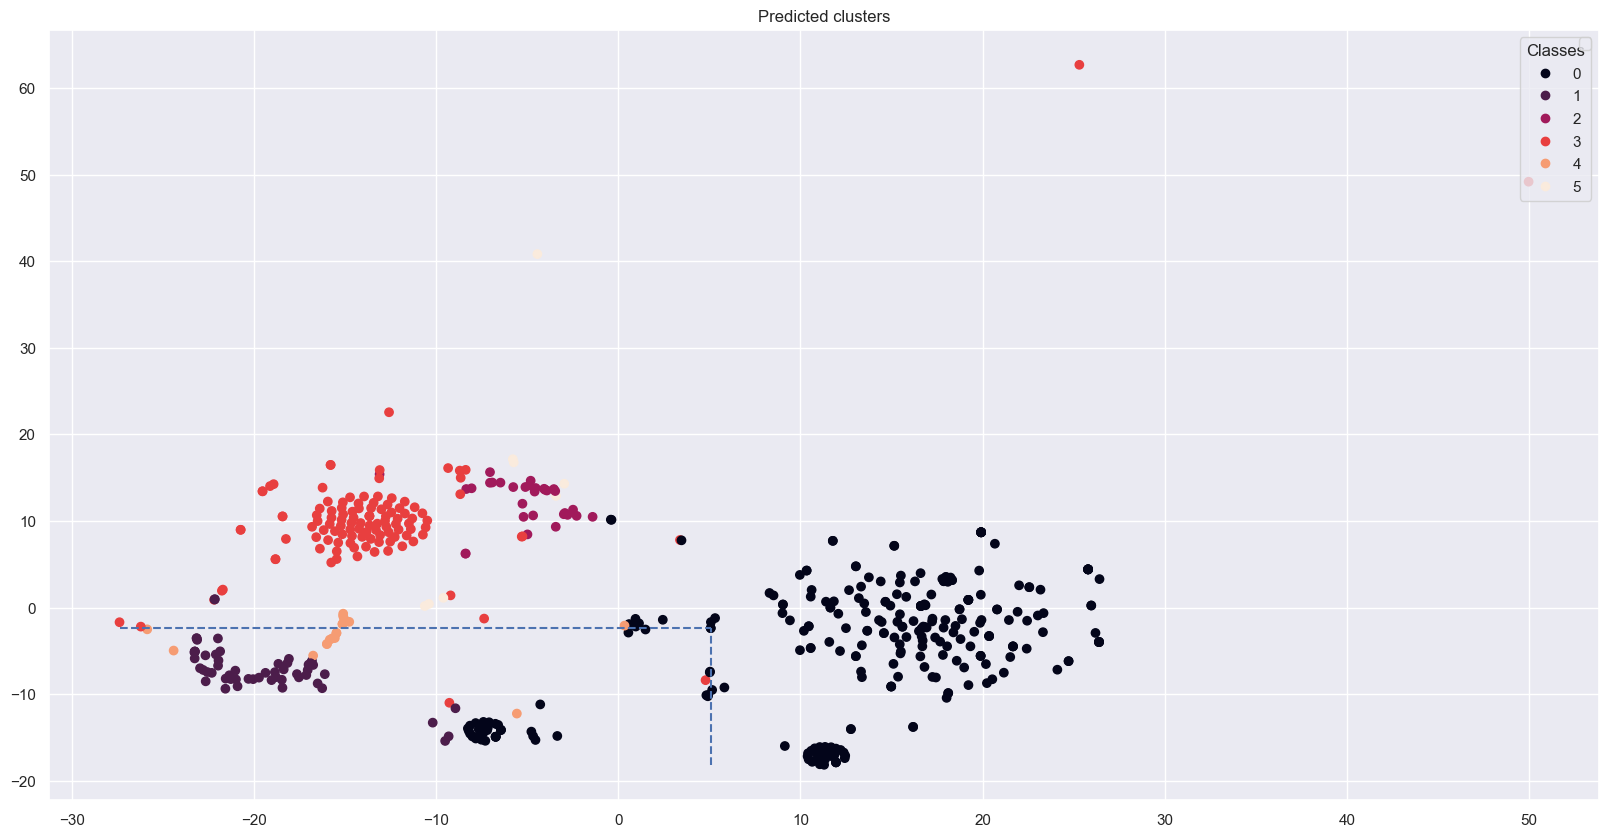

In [22]:
plot_results(dfs_prices_clusters['cluster'], tsne_transformed)

Observed, there are some tickets which are quite different from __BTC__, but are still in the same cluster with __BTC__.

### Show results for other time periods

day_30 dataset


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


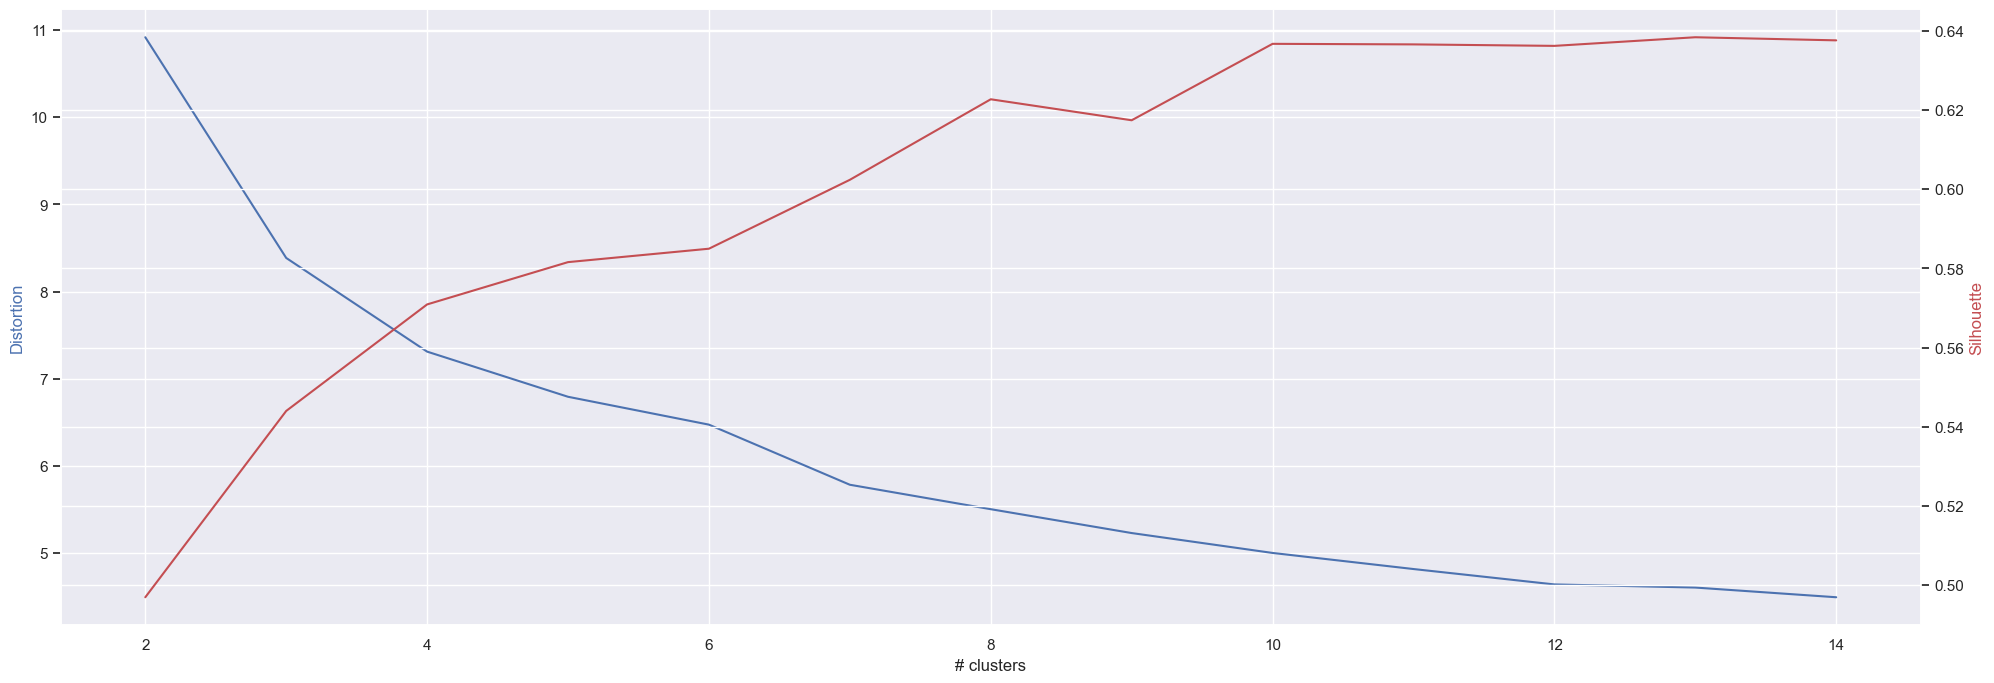

hour_72 dataset


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


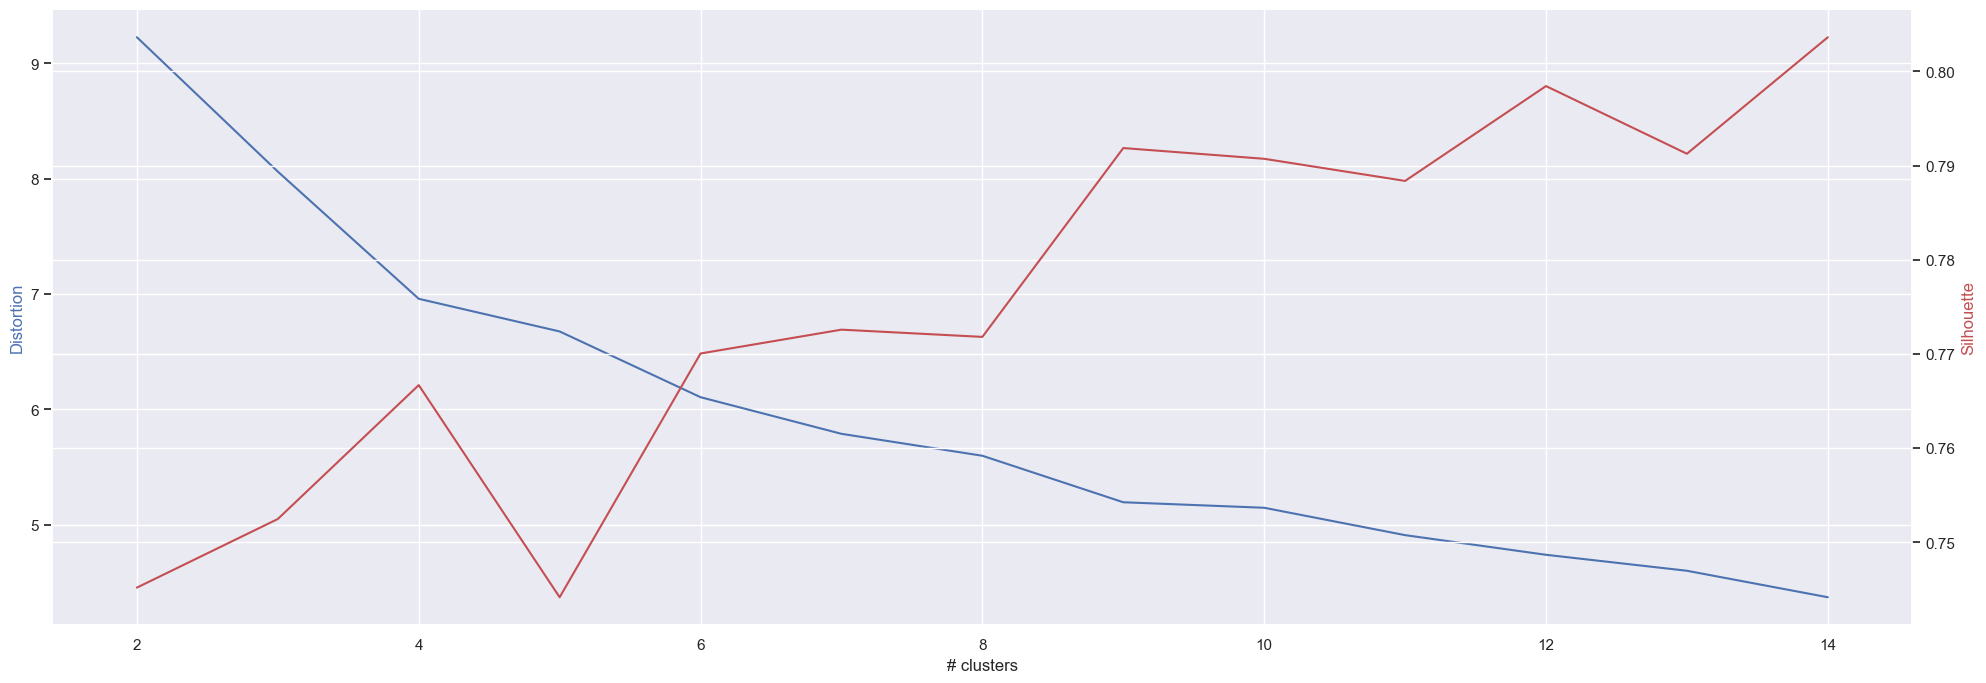

minute_60 dataset


100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


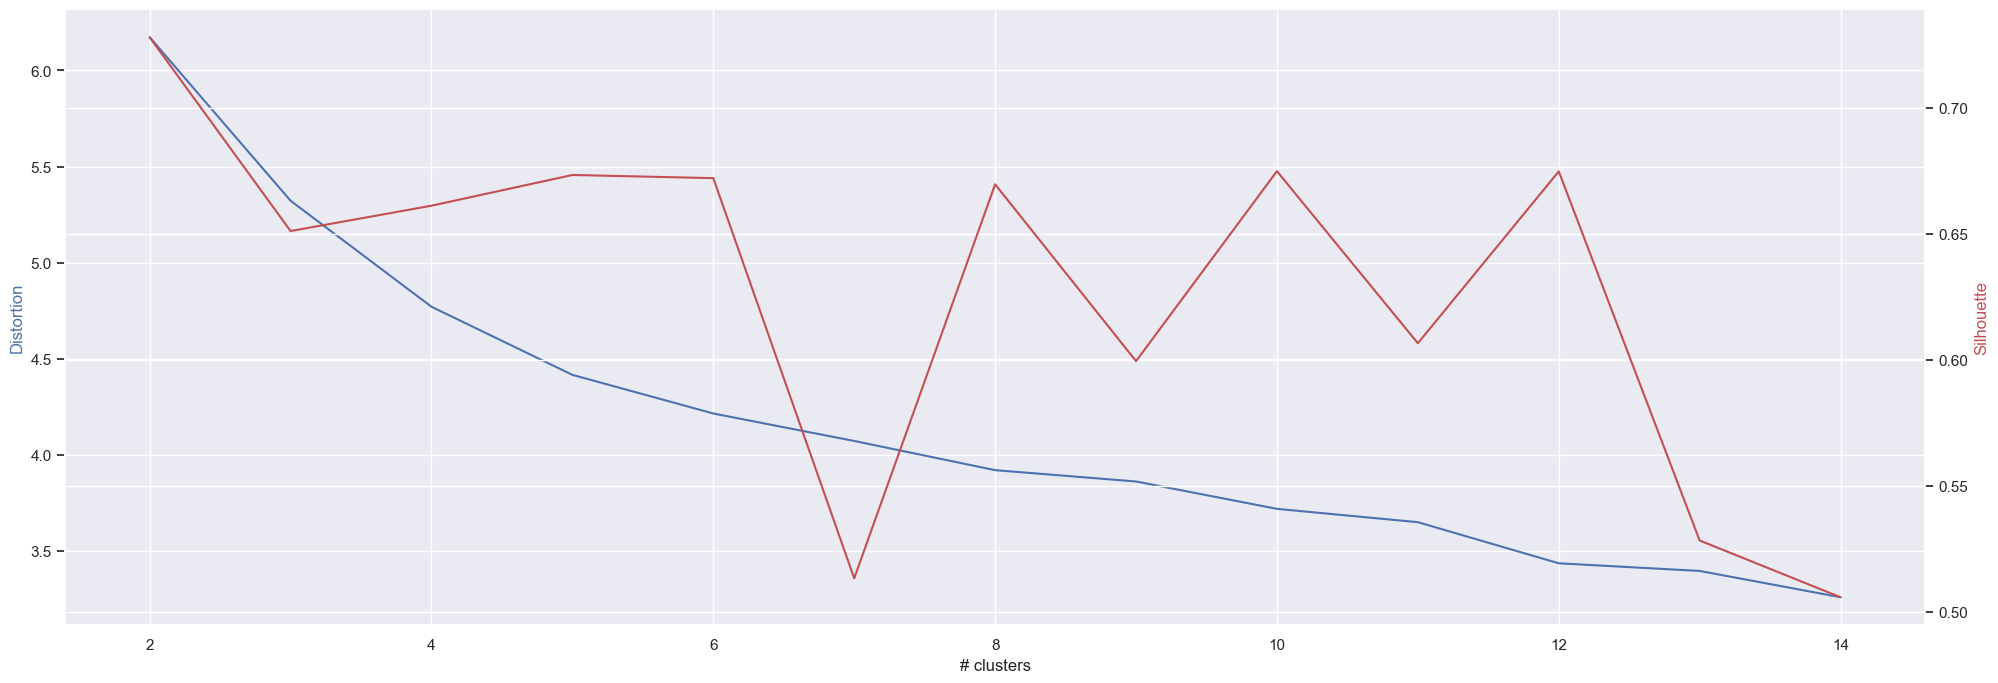

In [23]:
for df_name in DF_NAMES:
    print(f"{df_name} dataset")
    plot_elbow(dfs_prices_scaled[df_name], SEED)

In [24]:
# Base on plots choose following cluster numbers
# For case with 72 hours 6 and 9 cluster could be chosen
n_clusters = [6, 9, 6]
dfs_prices_clusters = {}
dict_ts_kmeans = {}

for df_name, n_cluster in zip(DF_NAMES, n_clusters):
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", n_jobs=6, max_iter=10, random_state=SEED)
    ts_kmeans.fit(dfs_prices_scaled[df_name])
    dict_ts_kmeans[df_name] = ts_kmeans
    dfs_prices_clusters[df_name] = dfs_prices[df_name].T
    dfs_prices_clusters[df_name]['cluster'] = ts_kmeans.predict(dfs_prices_scaled[df_name])

c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(


day_30 dataset
BTC cluster is: 0


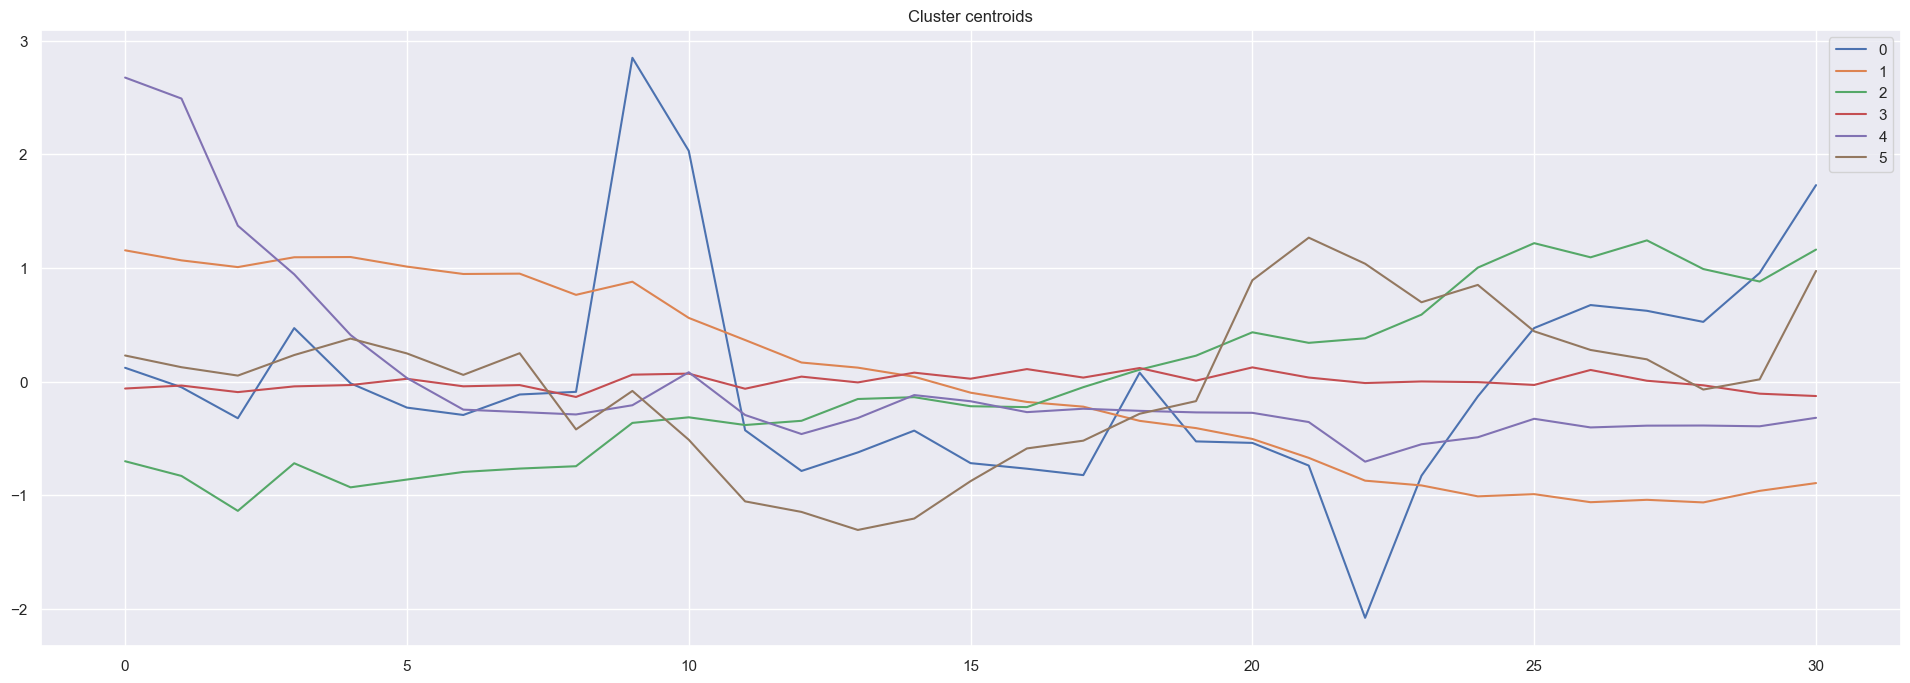

hour_72 dataset
BTC cluster is: 0


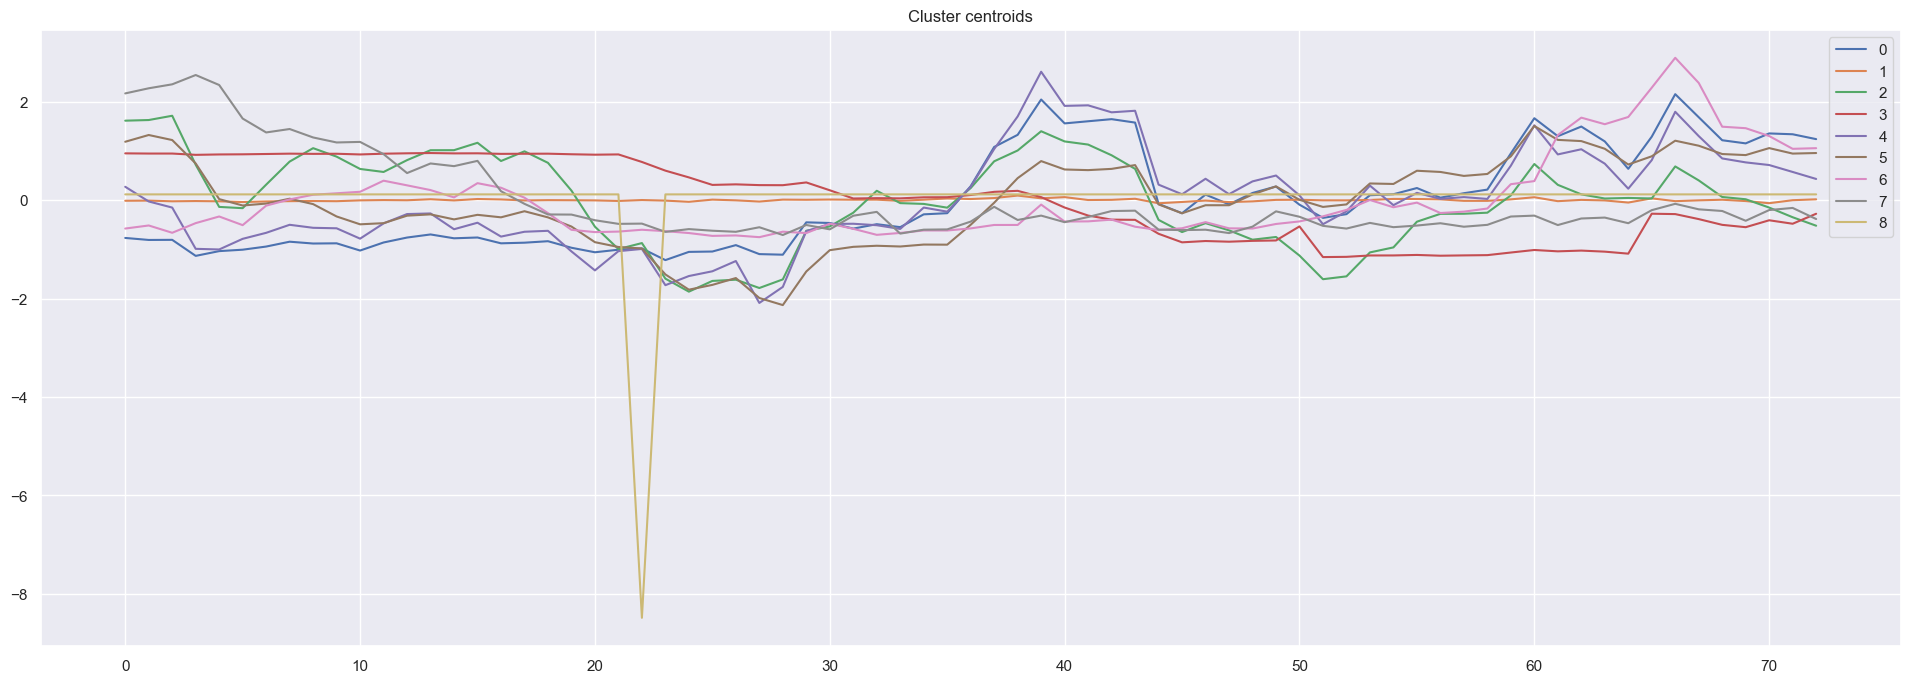

minute_60 dataset
BTC cluster is: 0


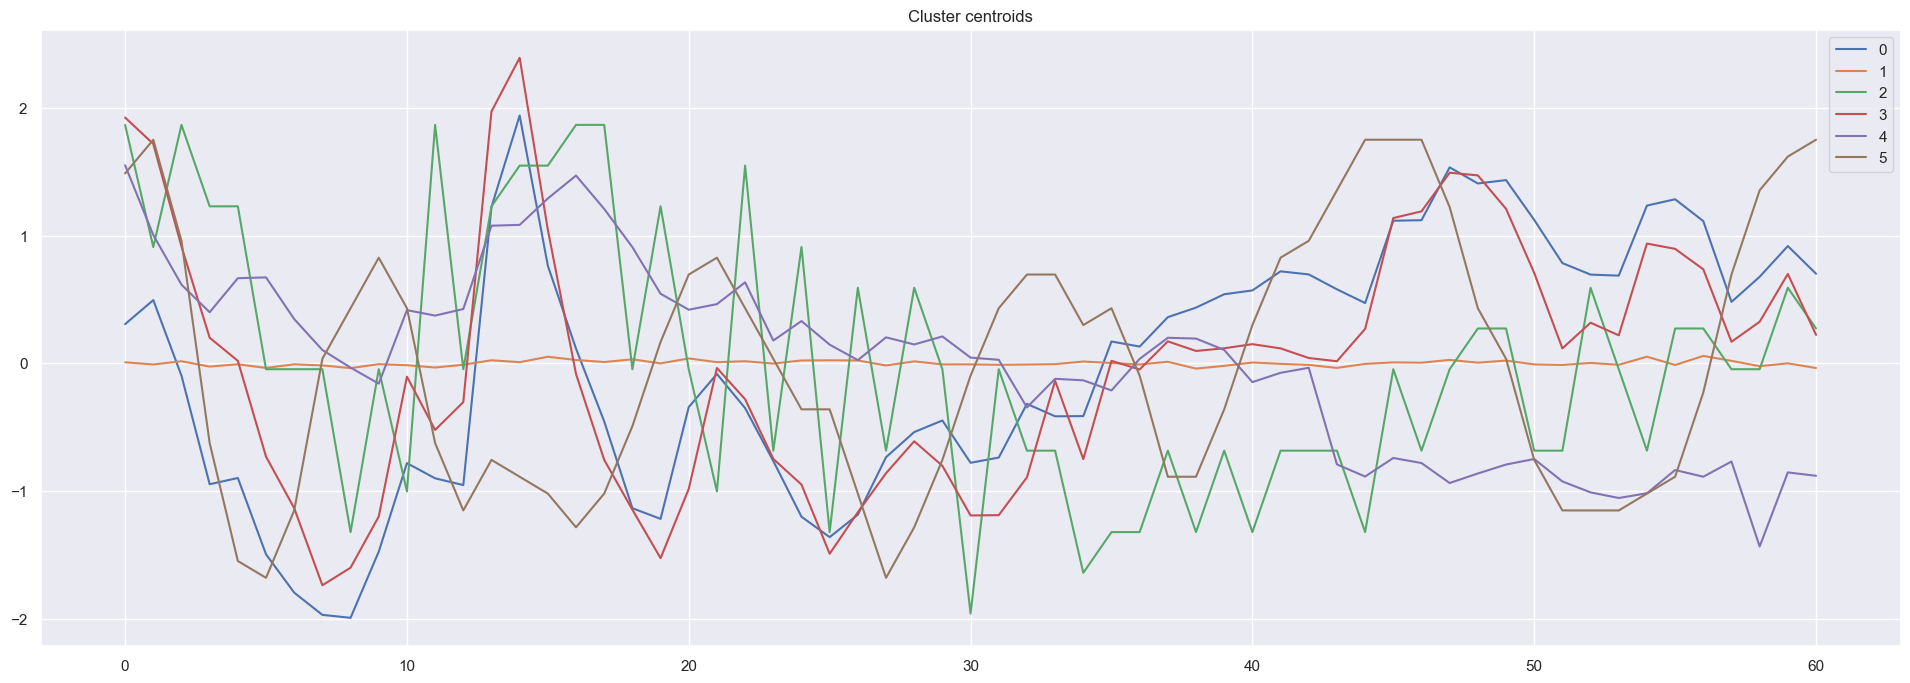

In [25]:
target_clusters = {}
for df_name, n_cluster in zip(DF_NAMES, n_clusters):
    print(f"{df_name} dataset")
    target_clusters[df_name] = dfs_prices_clusters[df_name].loc[TARGET_TICKET, 'cluster']
    print("BTC cluster is:", target_clusters[df_name])

    for cluster_number in range(n_cluster):
        plt.plot(dict_ts_kmeans[df_name].cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
    plt.title("Cluster centroids") # for Bulls and Bears
    plt.legend()
    plt.show()

Noticeable difference between the cluster __BTC__ based on 30 days data

Explained variance of 2 components 0.6656378890647714


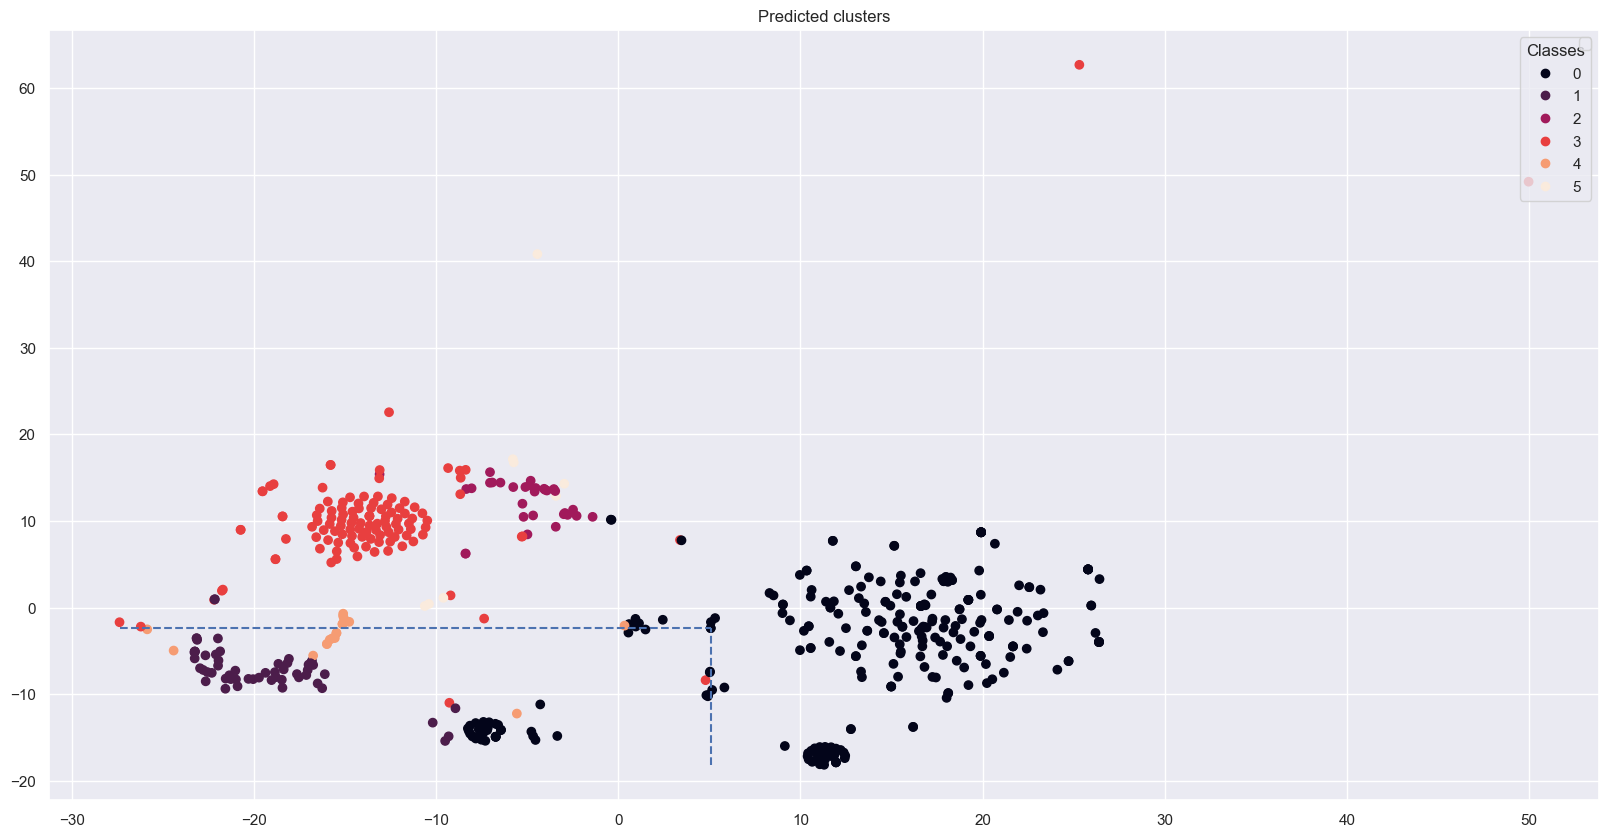

Explained variance of 2 components 0.7672748622876042


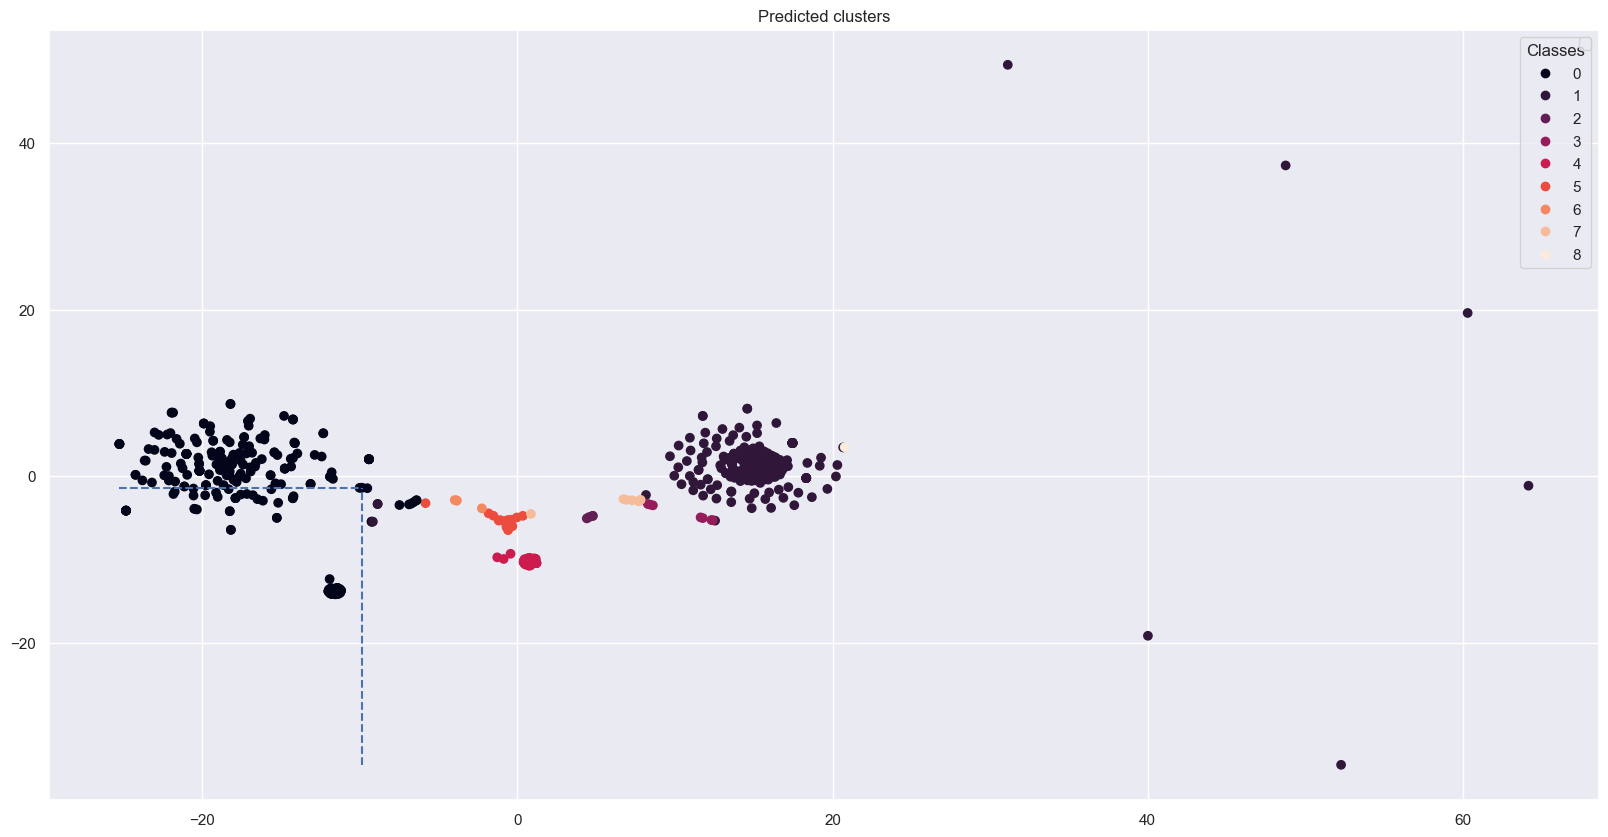

Explained variance of 2 components 0.7831442664811182


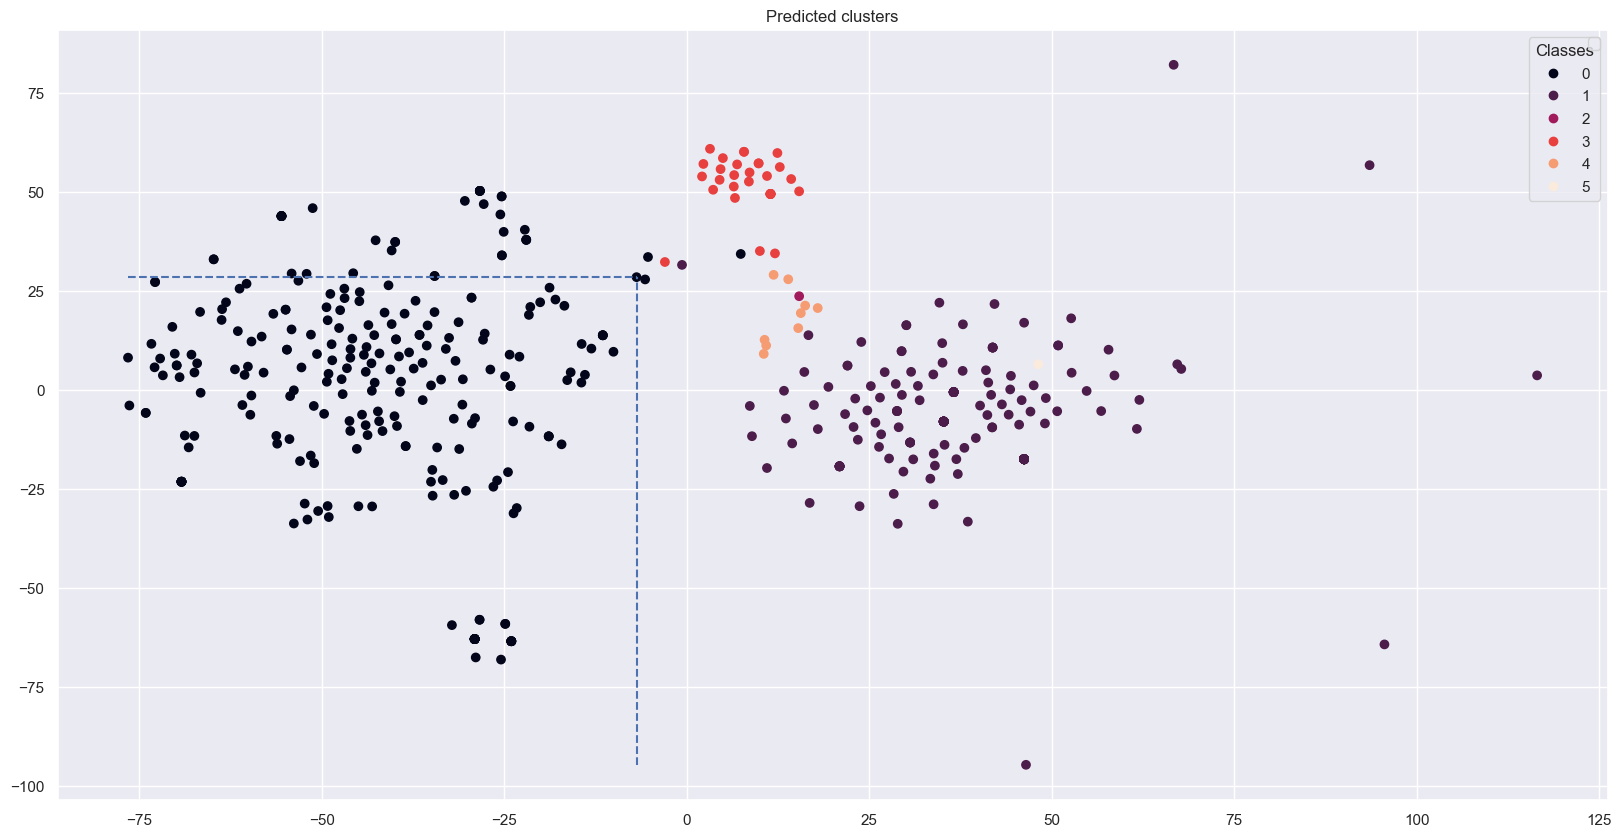

In [26]:
for df_name in DF_NAMES:
    pca_transformed = plot_and_get_pca(dfs_prices_scaled[df_name], SEED)
    tsne = TSNE(n_jobs=6, random_state=SEED)
    tsne_transformed = tsne.fit_transform(pca_transformed)
    plot_results(dfs_prices_clusters[df_name]['cluster'], tsne_transformed)

It is seen 30 days and 72 hours data __BTC__ are similar taking into account reduced number of clusters.

In [27]:
non_btc_tickets = get_non_btc_tickets(dfs_prices_clusters, target_clusters, DF_NAMES)

Different from BTC currencies in cluster day_30:
Not like BTC tickets day_30: 231 
 {'GBT', 'SHORTY', 'ARM', 'BLK', 'XCP', 'XBC', 'TIA', 'XSN', 'ALC', 'RDN', 'TRICK', 'ZET2', 'EGO', 'TDFB', 'HZT', 'RUST', 'VIP', 'YOC', 'EXP', 'JIF', 'PNC', 'LTS', 'XVG', 'BIGUP', 'CAB', 'VSL', 'CORAL', 'ICN', 'FRWC', 'XNX', 'FRE', 'SPOTS', 'NZC', 'SMC', 'SMSR', 'PSI', 'SLS', 'BIOS', 'IOC', 'PPC', 'ETHS', 'COVAL', 'FTC', 'PREM', 'NMC', 'EMC', 'GOON', 'VLT', 'DCRE', 'CREED', 'CYG', 'RUBIT', 'OMNI', 'STHR', 'HEDGE', 'EMC2', 'RMS', 'BSTAR', 'UNF', 'NXT', 'BTMK', 'CLR', 'PRM', 'HVCO', 'SNGLS', 'N7', 'ENE', 'VIA', 'GIG', 'THC', 'GLM', 'GRS', 'NEBU', 'MONETA', 'PIO', 'SCRPT', 'DOGETH', 'MONA', 'ODNT', 'LBC', 'XRP', 'GLC', 'HYP', 'CLUD', 'RDD', 'NTRN', 'DPAY', 'SP', 'DB', 'ZUR', 'UBIQ', 'ZOOM', 'PLNC', 'BTTF', 'SCASH', 'CSMIC', 'TAK', 'CRW', 'FIST', 'NBIT', 'RISEVISION', 'MAID', 'XPD', 'XDN', 'INCP', 'DISK', 'NETC', 'BFX', 'GROW', 'GB', 'ZNE', 'PINK', 'BSC', 'SEN', 'TITC', 'FIRO', 'EVIL', 'KRAK', 'COX', 'CRNK',

Tickets which common in all datasets in other clusters than BTC

In [28]:
non_btc_tickets_all = non_btc_tickets[0] & non_btc_tickets[1] & non_btc_tickets[2]
print("Not like BTC tickets", len(non_btc_tickets_all), '\n', non_btc_tickets_all)

Not like BTC tickets 203 
 {'GBT', 'SHORTY', 'ARM', 'XBC', 'TIA', 'XSN', 'ALC', 'RDN', 'TRICK', 'ZET2', 'EGO', 'TDFB', 'HZT', 'RUST', 'VIP', 'YOC', 'JIF', 'LTS', 'XVG', 'BIGUP', 'CAB', 'VSL', 'CORAL', 'ICN', 'FRWC', 'XNX', 'FRE', 'SPOTS', 'NZC', 'SMC', 'SMSR', 'PSI', 'SLS', 'BIOS', 'ETHS', 'COVAL', 'PREM', 'GOON', 'VLT', 'DCRE', 'CREED', 'CYG', 'RUBIT', 'OMNI', 'STHR', 'HEDGE', 'RMS', 'BSTAR', 'UNF', 'NXT', 'BTMK', 'CLR', 'PRM', 'HVCO', 'SNGLS', 'N7', 'ENE', 'VIA', 'GIG', 'GLM', 'ODNT', 'GRS', 'NEBU', 'MONETA', 'PIO', 'SCRPT', 'DOGETH', 'MONA', 'XRP', 'GLC', 'HYP', 'CLUD', 'RDD', 'DPAY', 'SP', 'DB', 'ZUR', 'UBIQ', 'ZOOM', 'PLNC', 'BTTF', 'CSMIC', 'TAK', 'FIST', 'NBIT', 'RISEVISION', 'XPD', 'INCP', 'DISK', 'NETC', 'BFX', 'GROW', 'GB', 'ZNE', 'BSC', 'SEN', 'TITC', 'FIRO', 'EVIL', 'KRAK', 'COX', 'CRNK', 'BCN', 'PCM', 'CLUB', 'CYT', 'JWL', 'CIN', 'EXIT', 'BTS', 'NXE', 'BBCC', 'EDUC', 'TAGR', 'TOT', 'BTCR', 'EDGE', 'BNT', '365', 'WMC', 'FGZ', 'CLINT', 'NUBIS', 'TENNET', 'LIR', 'HODL', 'TUR'

It is seen, many tickets are the same (in different clusters regarding __BTC__) for different time periods and discreteness.

# 8. Clustering, DTW

In [29]:
dfs_prices_clusters = {}
dict_ts_kmeans = {}

for df_name, n_cluster in zip(DF_NAMES, n_clusters):
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", n_jobs=6, max_iter=10, random_state=SEED)
    ts_kmeans.fit(dfs_prices_scaled[df_name])
    dict_ts_kmeans[df_name] = ts_kmeans
    dfs_prices_clusters[df_name] = dfs_prices[df_name].T
    dfs_prices_clusters[df_name]['cluster'] = ts_kmeans.predict(dfs_prices_scaled[df_name])

c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(


day_30 dataset
BTC cluster is: 1


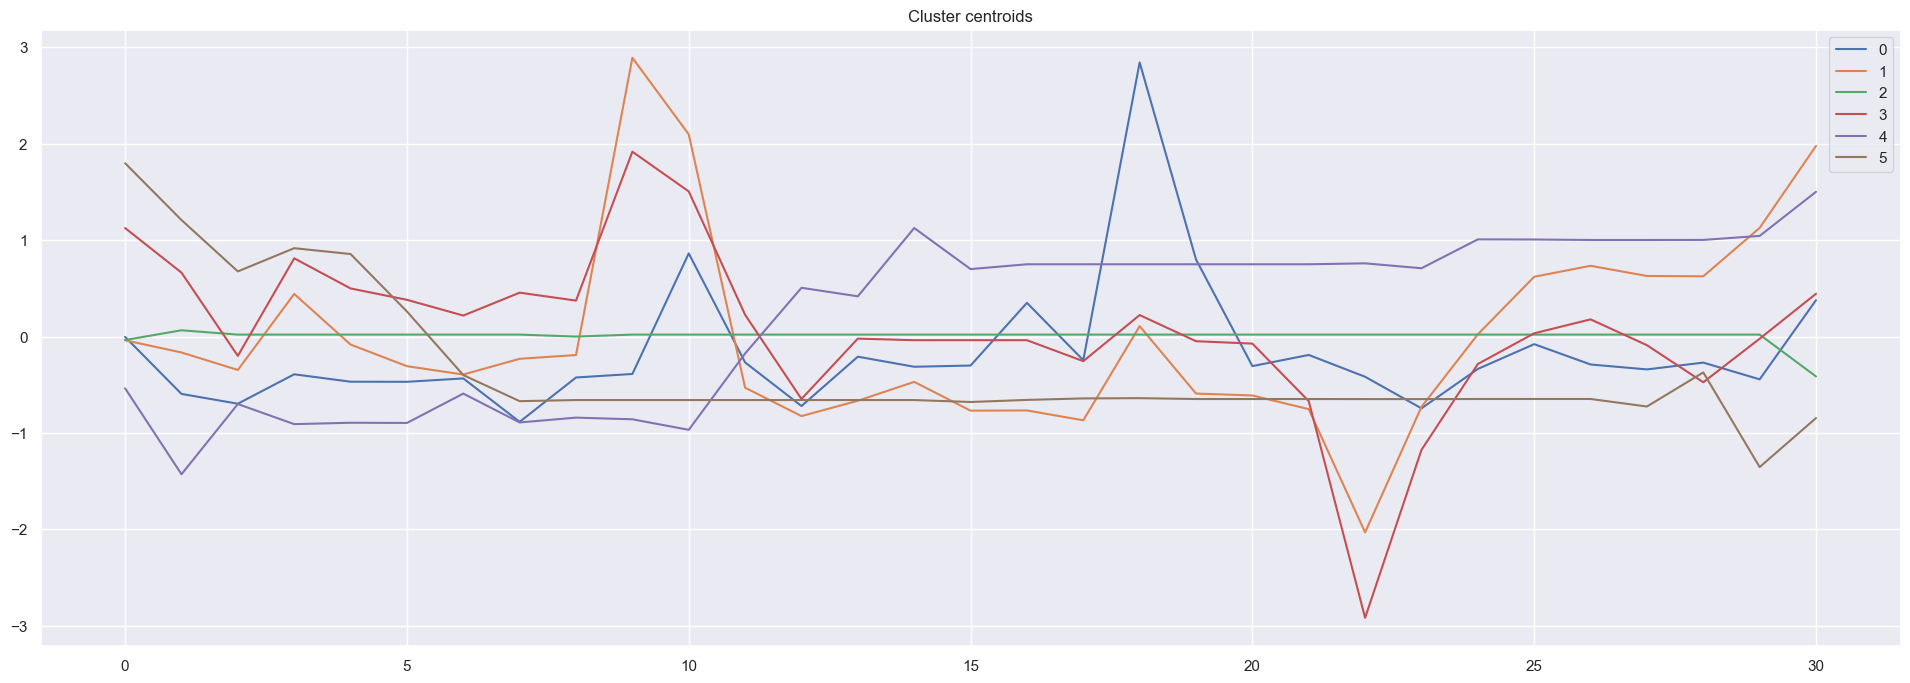

hour_72 dataset
BTC cluster is: 1


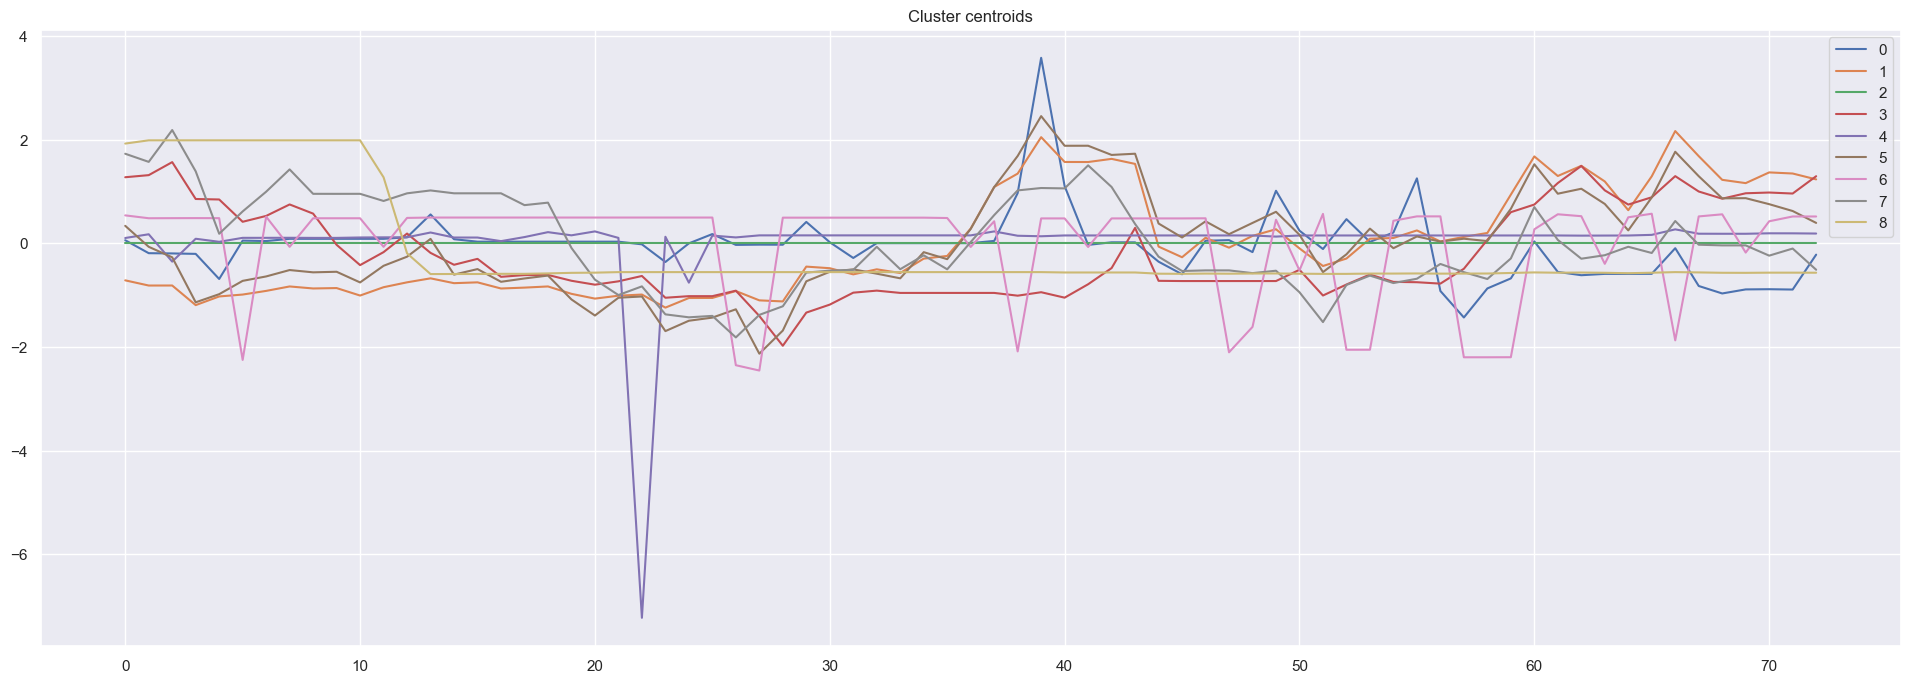

minute_60 dataset
BTC cluster is: 4


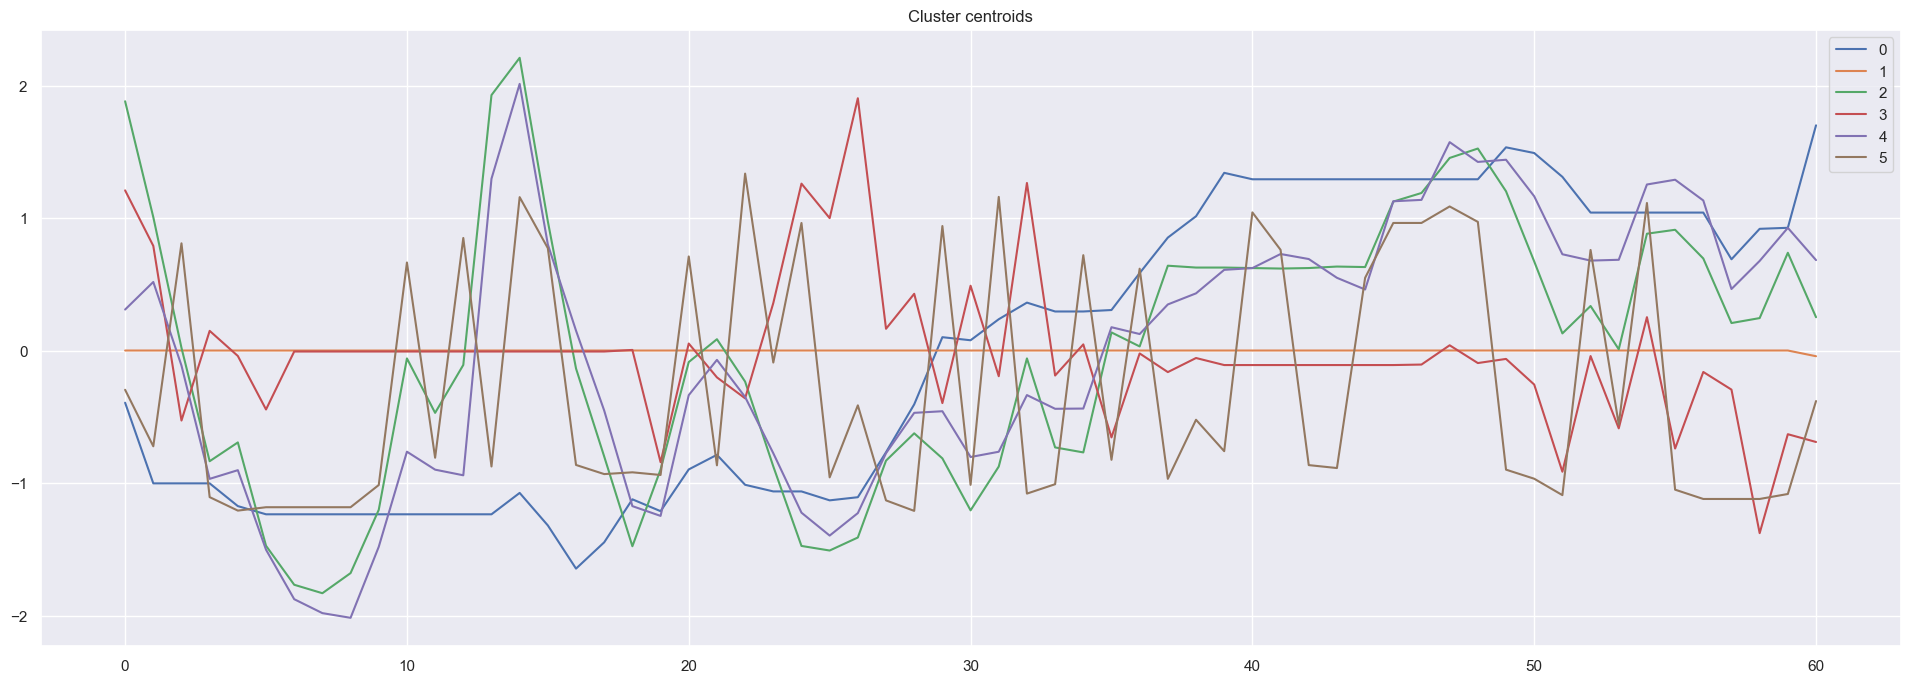

In [30]:
target_clusters = {}
for df_name, n_cluster in zip(DF_NAMES, n_clusters):
    print(f"{df_name} dataset")
    target_clusters[df_name] = dfs_prices_clusters[df_name].loc[TARGET_TICKET, 'cluster']
    print("BTC cluster is:", target_clusters[df_name])

    for cluster_number in range(n_cluster):
        plt.plot(dict_ts_kmeans[df_name].cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
    plt.title("Cluster centroids")
    plt.legend()
    plt.show()

Explained variance of 2 components 0.6656378890647714


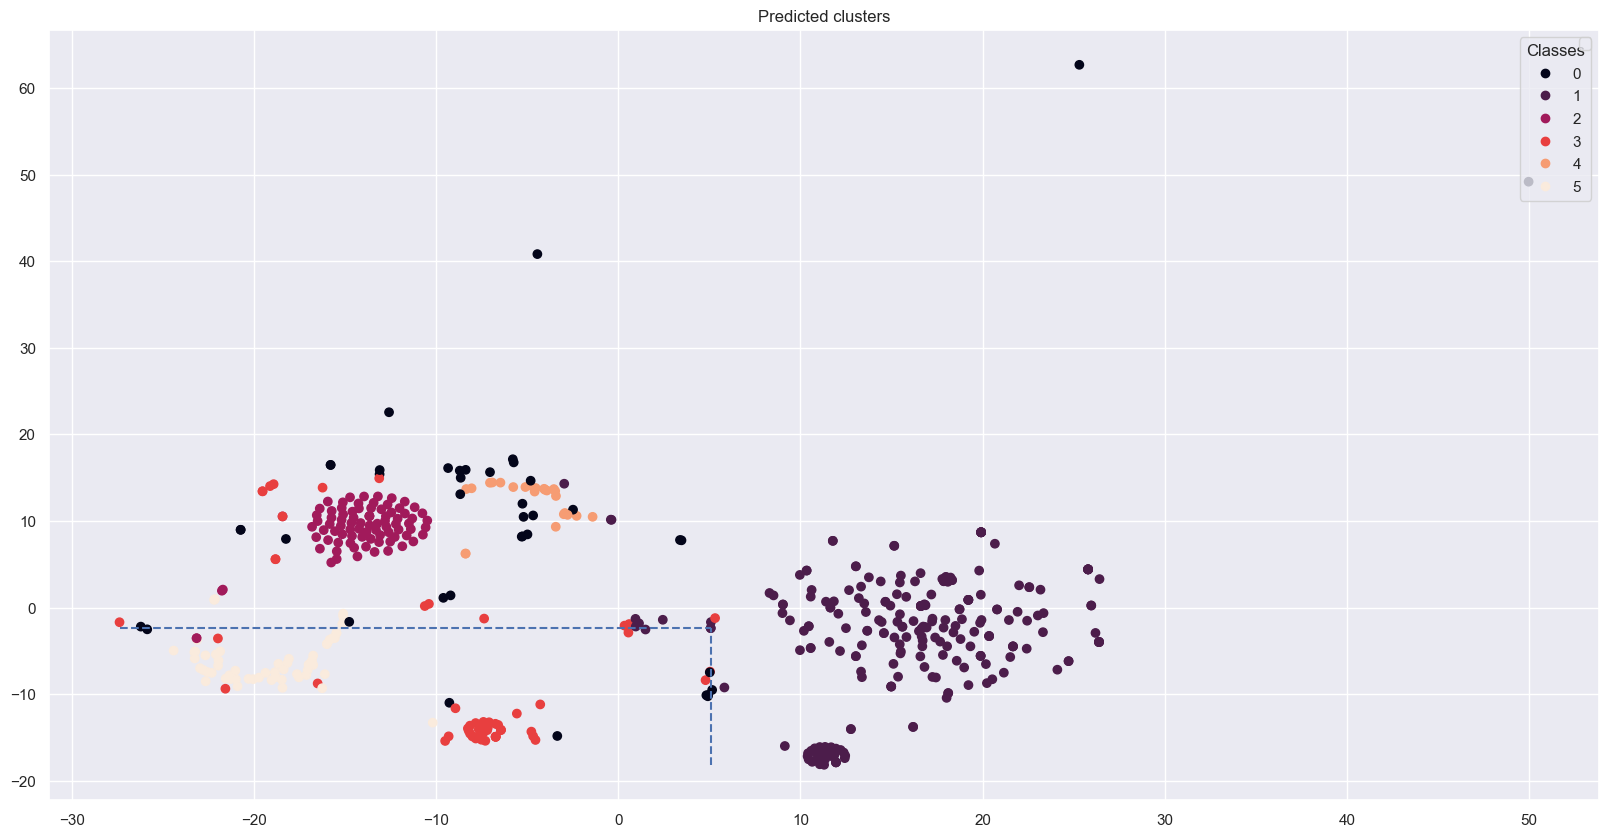

Explained variance of 2 components 0.7672748622876042


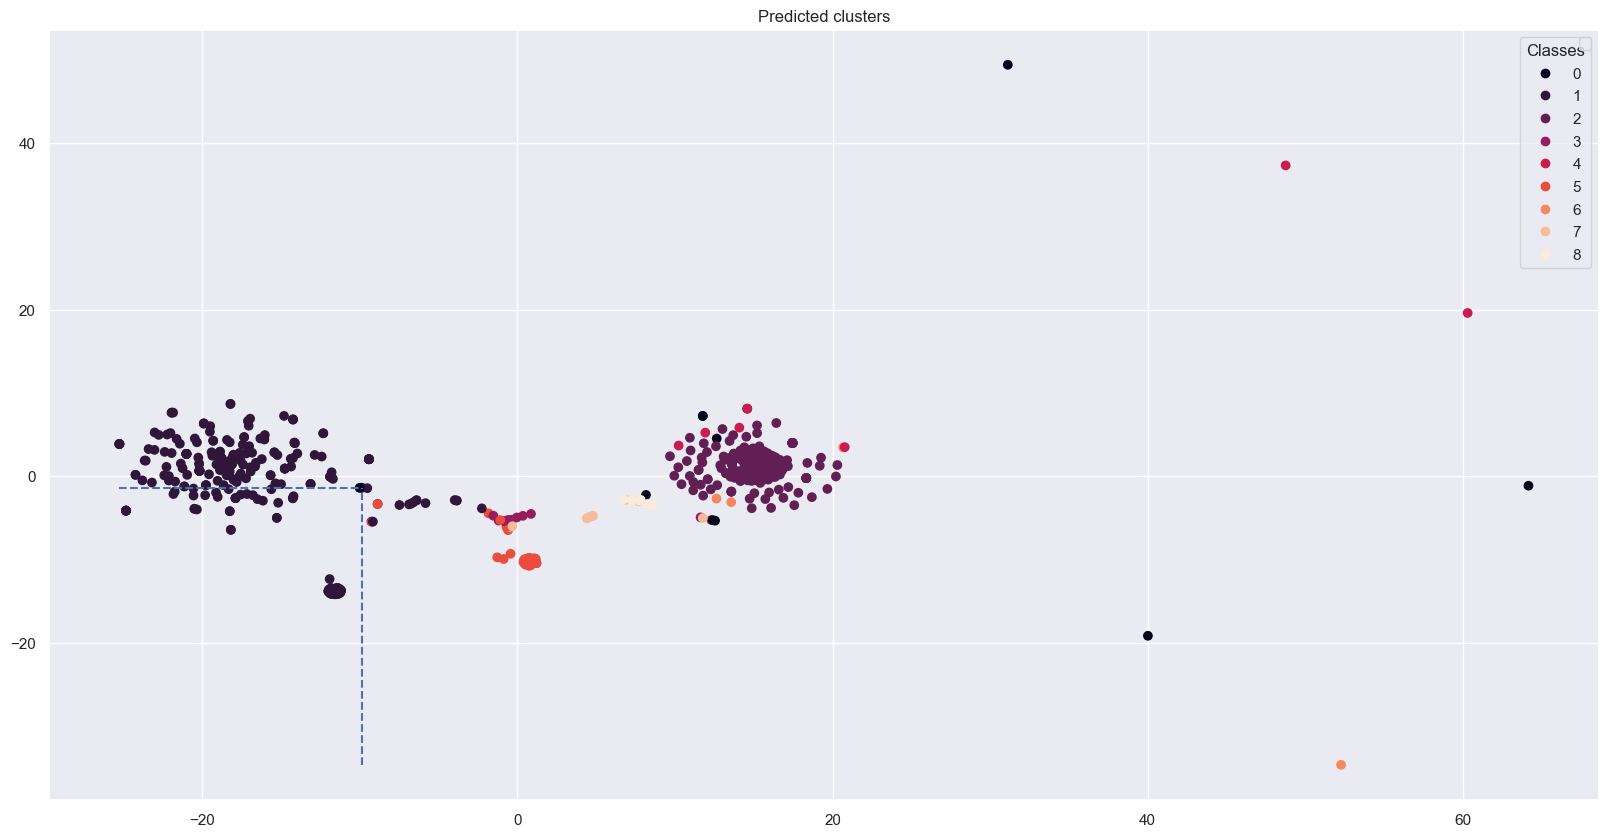

Explained variance of 2 components 0.7831442664811182


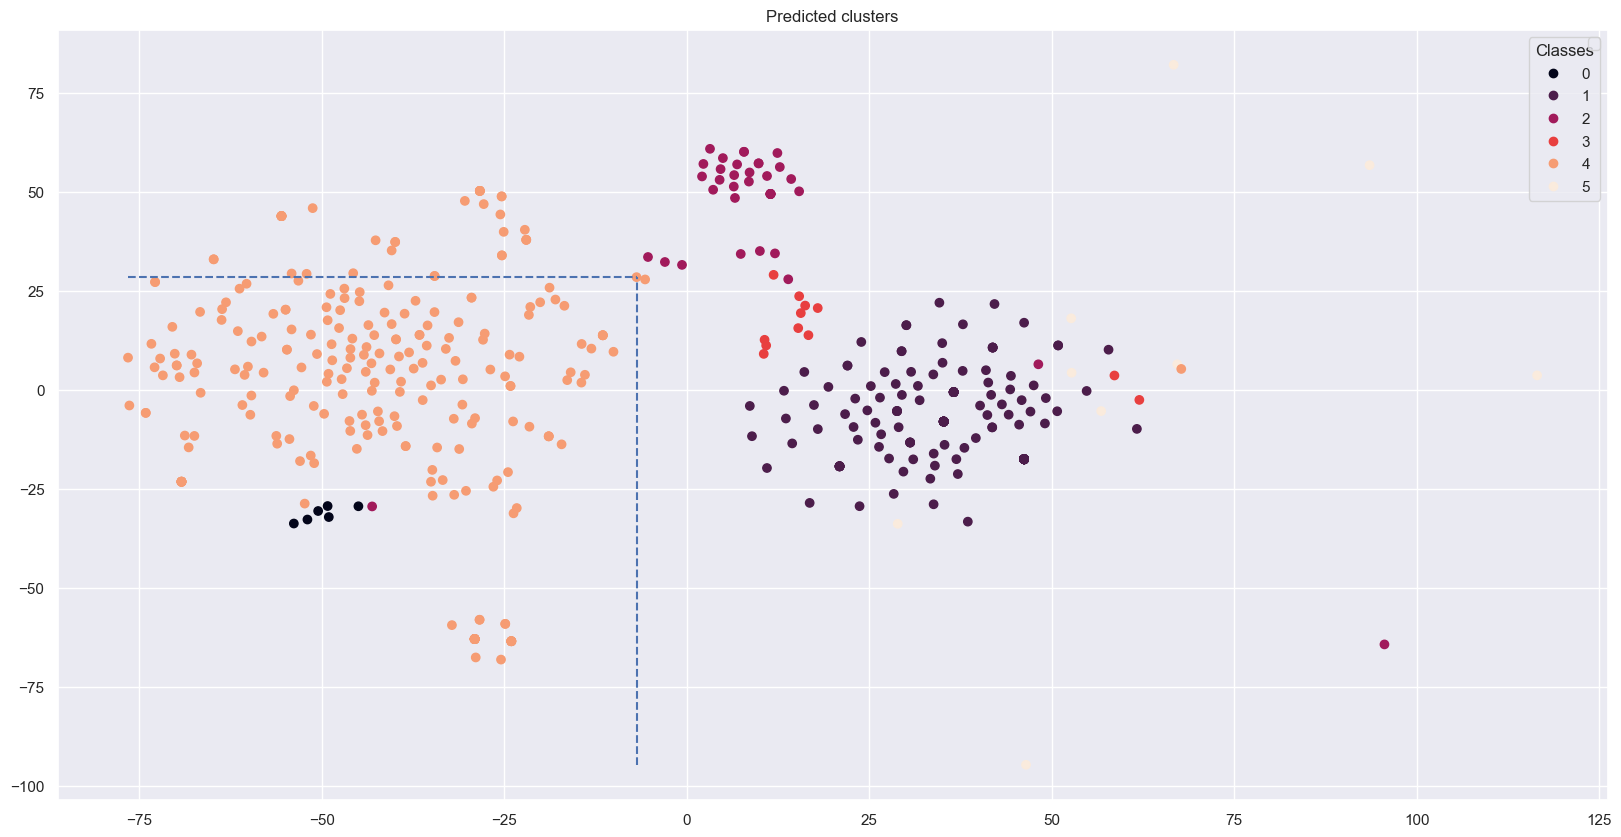

In [31]:
for df_name in DF_NAMES:
    pca_transformed = plot_and_get_pca(dfs_prices_scaled[df_name], SEED)
    tsne = TSNE(n_jobs=6, random_state=SEED)
    tsne_transformed = tsne.fit_transform(pca_transformed)
    plot_results(dfs_prices_clusters[df_name]['cluster'], tsne_transformed)

In [32]:
non_btc_tickets_dtw = get_non_btc_tickets(dfs_prices_clusters, target_clusters, DF_NAMES)
non_btc_tickets_all_dtw  = non_btc_tickets_dtw[0] & non_btc_tickets_dtw[1] & non_btc_tickets_dtw[2]
print("Not like BTC tickets", len(non_btc_tickets_all_dtw), '\n', non_btc_tickets_all_dtw)

Different from BTC currencies in cluster day_30:
Not like BTC tickets day_30: 271 
 {'GBT', 'LTC', 'DASH', 'BCCOIN', 'ARM', 'SHORTY', 'BLK', 'XCP', 'XBC', 'TIA', 'XSN', 'ALC', 'CSC', 'RDN', 'TRICK', 'UFOCOIN', 'ZET2', 'PULSE', 'EGO', 'TDFB', 'HZT', 'RUST', 'VIP', 'YOC', 'EXP', 'JIF', 'SLR', 'PNC', 'LTS', 'XVG', 'BIGUP', 'CAB', 'VSL', 'CORAL', 'ICN', 'FRWC', 'XNX', 'FRE', 'MEME', 'SPOTS', 'NZC', 'SMC', 'BOBS', 'SMSR', 'DCR', 'LIV', 'ISL', 'PSI', 'SLS', 'BIOS', 'ETHS', 'PPC', 'EPY', 'COVAL', 'FTC', 'PREM', 'NMC', 'EMC', 'GOON', 'VLT', 'DCRE', 'CREED', 'CYG', 'RUBIT', 'OMNI', 'STHR', 'NEOS', 'EMC2', 'HEDGE', 'RMS', 'BSTAR', 'UNF', 'NXT', 'BTMK', 'CLR', 'PRM', 'HVCO', 'SNGLS', 'N7', 'ENE', 'VIA', 'GIG', 'FUZZ', 'THC', 'GRS', 'NEBU', 'MONETA', 'PIO', 'SCRPT', 'GLM', 'MONA', 'DOGETH', 'LBC', 'DGDC', 'XRP', 'GLC', 'HYP', 'SC', 'CLUD', 'RDD', 'NTRN', 'DPAY', 'SP', 'DB', 'ZUR', 'UBIQ', 'ZOOM', 'PLNC', 'BTTF', 'SCASH', 'BTCD', 'CSMIC', 'TAK', 'XPM', 'CRW', 'NBIT', 'RISEVISION', 'FIST', 'MAID', '

Generally, DTW method separates more tickets

# 9. Outcome

In [33]:
print("Separated by basic kNN:", len(non_btc_tickets_all))
print("Separated by kNN DTW method:", len(non_btc_tickets_all_dtw))

Separated by basic kNN: 203
Separated by kNN DTW method: 235


Let's see which tickets are the same (looks different than BTC) in both methods.

In [34]:
non_btc_tickets_all_both = non_btc_tickets_all_dtw & non_btc_tickets_all
print("In both cases nto-like BTC tickets are follwoing:", len(non_btc_tickets_all_both), '\n', non_btc_tickets_all_both)

In both cases nto-like BTC tickets are follwoing: 199 
 {'GBT', 'SHORTY', 'ARM', 'XBC', 'TIA', 'XSN', 'ALC', 'TRICK', 'ZET2', 'EGO', 'TDFB', 'HZT', 'RUST', 'VIP', 'YOC', 'JIF', 'LTS', 'XVG', 'BIGUP', 'CAB', 'VSL', 'CORAL', 'ICN', 'XNX', 'FRE', 'SPOTS', 'NZC', 'SMC', 'SMSR', 'PSI', 'SLS', 'BIOS', 'ETHS', 'COVAL', 'PREM', 'GOON', 'VLT', 'DCRE', 'CREED', 'CYG', 'RUBIT', 'OMNI', 'STHR', 'HEDGE', 'BSTAR', 'RMS', 'UNF', 'NXT', 'BTMK', 'CLR', 'PRM', 'HVCO', 'SNGLS', 'N7', 'ENE', 'VIA', 'GIG', 'GLM', 'ODNT', 'GRS', 'NEBU', 'MONETA', 'PIO', 'SCRPT', 'DOGETH', 'MONA', 'GLC', 'HYP', 'CLUD', 'RDD', 'DPAY', 'SP', 'DB', 'ZUR', 'UBIQ', 'ZOOM', 'PLNC', 'BTTF', 'CSMIC', 'TAK', 'FIST', 'NBIT', 'RISEVISION', 'XPD', 'INCP', 'DISK', 'NETC', 'BFX', 'GROW', 'GB', 'ZNE', 'BSC', 'SEN', 'TITC', 'FIRO', 'EVIL', 'KRAK', 'COX', 'CRNK', 'BCN', 'PCM', 'CLUB', 'CYT', 'JWL', 'CIN', 'EXIT', 'BTS', 'NXE', 'BBCC', 'EDUC', 'TAGR', 'TOT', 'BTCR', 'EDGE', 'BNT', '365', 'WMC', 'FGZ', 'CLINT', 'NUBIS', 'TENNET', 'LIR', 'HODL'

__Totaly, Dynamic Time Warping (DTW) show more tickets with different behaviour than BTC. Moreover most of tickets from TimeSeriesKMeans clusterization are in DTW set__